# Mini-project: K-means algorithm

## <u>Preprocessing</u>

In [1]:
# before executing:
# pip install ucimlrepo

In [2]:
from ucimlrepo import fetch_ucirepo 
import random
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, f1_score
from scipy.stats import mode
from ucimlrepo import fetch_ucirepo

In [3]:
dataset_ids =   {
                "parkinsons": 174,
                "page-blocks": 78,
                "optical": 80,
                "musk2": 75,
                "bc-wisc-diag": 17,
                "students": 697,
                "wine": 109,
                "magic": 159,
                "balance-scale": 12,
                "glass": 42,
                "zoo": 111,
                "waveform": 107,
                "image-segmentation": 50,
                "blood": 176,
                "spect": 95,
                "yeast": 110,
                "monk": 70,
                "ecoli": 39,
                "iris": 53,
                "contraception": 30,
                "fertility": 244,
                "conn-bench-sonar":  151,
                "landsat": 146,
                "ionosphere": 52,
                "letter": 59,
                }

In [4]:
def load_dataset(id):  
    # fetch dataset 
    dataset = fetch_ucirepo(id=id) 
    
    # data (as pandas dataframes) 
    X = dataset.data.features 
    y =dataset.data.targets 
    
    # dictionary gthering infos about the metadata (url, abstract, ... etc.)
    metadata_infos_dict = dataset.metadata
    print('data url:\n', metadata_infos_dict['data_url'])
    
    # variable information
    var_infos = dataset.variables.to_numpy()
    
    data_vectors = X.to_numpy() #instance vectors with features
    features_names = X.columns.to_numpy() #getting the names of each feature
    
    data_labels = y.to_numpy() #output labels for each instance
    label_name = y.columns.to_numpy() # name of the output label
    
    return data_vectors, features_names, data_labels, label_name

In [5]:
def print_useful_data(X, X_names, y, y_name, index = 0):
    n_instances = len(X)
    n_features = len(X_names)
    
    print("number of instances: ", n_instances)
    print("number of features: ", n_features)

    print("names of the features:\n", X_names) #features' names
    print("name of the output label: ", y_name)

    print(f"instance {index} feature vector:\n", X[index])
    print(f"instance {index} output label: ", y[index])

In [6]:
def preprocessing(X, y, split = 0.7):
    scaler = StandardScaler()
    try:
        #standardization
        X = scaler.fit_transform(X)
    except ValueError:
        #If non numerical data is detected, data is encoded
        X = np.array(X, dtype=object) 
        encoder = OneHotEncoder()
        X_encoded = encoder.fit_transform(X).toarray()
        X = scaler.fit_transform(X_encoded)  
    
    #data is split among training and testing sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, train_size=split, random_state=42)
    
    return X_train, Y_train, X_test, Y_test

## <u>K-means core algorithm and cross validation</u>

In [7]:
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

In [8]:
#main body, centroids and clusters are computed until convergence is reached
def k_means(X, k, max_iters=100, tol=1e-4, visualization = True, display_iteration = 8):
    #at first centroids are initialized at random
    np.random.seed(42)
    centroids = X[random.sample(range(X.shape[0]), k)]

    for iteration in range(max_iters):
        #clusters are assigned based on closest centroids
        clusters = [[] for _ in range(k)]
        for idx, point in enumerate(X):
            distances = [euclidean_distance(point, centroid) for centroid in centroids]
            cluster_idx = np.argmin(distances)
            clusters[cluster_idx].append(idx)

        #centroids are updated by calculating the mean of assigned points
        new_centroids = np.zeros_like(centroids)
        for i, cluster in enumerate(clusters):
            if cluster:
                new_centroids[i] = np.mean(X[cluster], axis=0)
            else:
                new_centroids[i] = centroids[i]  #avoid empty cluster
        
        #visualization of clusters and centroids every 8 iterations (or chosen value of display_iteration)
        if iteration%display_iteration == 0 and visualization == True:
            cluster_labels = np.zeros(X.shape[0])
            for cluster_idx, cluster in enumerate(clusters):
                for point_idx in cluster:
                    cluster_labels[point_idx] = cluster_idx
            visualize_clusters(X, clusters, new_centroids, iteration + 1, k, cluster_labels)


        #convergence check
        convergence = np.linalg.norm(new_centroids - centroids)
        if convergence < tol:
            break

        centroids = new_centroids

    # final centroids and cluster assignments
    cluster_labels = np.zeros(X.shape[0])
    for cluster_idx, cluster in enumerate(clusters):
        for point_idx in cluster:
            cluster_labels[point_idx] = cluster_idx

    return centroids, cluster_labels

In [9]:
#cross-validation function to select the best k
def cross_validation(X, y, k_values, n_splits=5):
    best_k = None
    best_accuracy = -1
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for k in k_values:
        accuracies = []

        #cross-validation is done for iterated k
        for train_index, val_index in kf.split(X):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            #K-means on the folded sets
            centroids, cluster_labels = k_means(X_train, k, visualization = False)

            #clusters prediction on the validation set
            cluster_labels_val = np.array([np.argmin([euclidean_distance(point, centroid) for centroid in centroids]) for point in X_val])

            #accuracy on the validation set
            accuracy, f1, cm = calculate_metrics(cluster_labels_val, y_val, compute_f1_cm = False)
            accuracies.append(accuracy)

        #calculate the accuracy for the iterated k
        avg_accuracy = np.mean(accuracies)
        print(f"predicted accuracy for k={k}: {avg_accuracy * 100:.2f}%")

        #keeps in memory the best k based on accuracy 
        if avg_accuracy > best_accuracy:
            best_accuracy = avg_accuracy
            best_k = k

    return best_k

## <u>Visualization function</u>

In [10]:
#function to visualize clusters using PCA
def visualize_clusters(X, clusters, centroids, iteration, nb_cluster, cluster_labels=None):
    plt.figure(figsize=(8, 6))
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']  #define colors for clusters

    #reduce the data to 2D using PCA for visualization
    pca = PCA(n_components=2)
    X_2D = pca.fit_transform(X) 

    #if cluster assignments are provided, color by cluster membership
    if cluster_labels is not None:
        for i in range(nb_cluster):
            cluster_points_2D = X_2D[cluster_labels == i]
            plt.scatter(cluster_points_2D[:, 0], cluster_points_2D[:, 1], 
                        color=colors[i % len(colors)], label=f'Cluster {i+1}')
    else:
        for i, cluster in enumerate(clusters):
            cluster_points = np.array(cluster)
            cluster_points_2D = pca.transform(cluster_points)  #transform current cluster into 2D
            plt.scatter(cluster_points_2D[:, 0], cluster_points_2D[:, 1], 
                        color=colors[i % len(colors)], label=f'Cluster {i+1}')

    #plot centroids in 2D space
    centroids_2D = pca.transform(centroids)  #transform centroids into 2D
    plt.scatter(centroids_2D[:, 0], centroids_2D[:, 1], 
                color='black', marker='x', s=200, label='Centroids')

    plt.title(f"clusters and centroids - Iteration {iteration}")
    plt.legend()
    plt.show()

## <u>Accuracy, F1 and confusion matrice</u>

In [11]:
def calculate_metrics(cluster_labels, true_labels, compute_f1_cm = True):
    unique_labels = np.unique(true_labels)
    label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
    int_labels = np.array([label_to_int[label] for label in true_labels.ravel()])

    #map clusters to most frequent true labels
    cluster_to_label = {}
    for cluster in np.unique(cluster_labels):
        mask = cluster_labels == cluster
        if np.any(mask):
            most_common_label, _ = mode(int_labels[mask], axis=None)
            cluster_to_label[cluster] = most_common_label.item()  
        else:
            cluster_to_label[cluster] = -1  #avoid empty clusters

    #predicted labels
    predicted_labels = np.array([cluster_to_label[cluster] for cluster in cluster_labels])

    #compute accuracy
    accuracy = np.mean(predicted_labels == int_labels)
    
    f1 = None
    cm = None
    if compute_f1_cm == True: 
        #compute F1 score
        f1 = f1_score(int_labels, predicted_labels, average='macro')
    
        #compute confusion matrix
        cm = confusion_matrix(int_labels, predicted_labels)

    return accuracy, f1, cm

## <u>Results on 25 datasets</u>

### Predict Students' Dropout and Academic Success

In [12]:
X, X_names, y, y_name = load_dataset(id = dataset_ids["students"])
split_size = 0.7
X_train, Y_train, X_test, Y_test = preprocessing(X, y, split_size)
print(f'training set size: {X_train.shape}')
print(f'testing set size: {X_test.shape}')

data url:
 https://archive.ics.uci.edu/static/public/697/data.csv
training set size: (3096, 36)
testing set size: (1328, 36)


In [13]:
print_useful_data(X, X_names, y, y_name)

number of instances:  4424
number of features:  36
names of the features:
 ['Marital Status' 'Application mode' 'Application order' 'Course'
 'Daytime/evening attendance' 'Previous qualification'
 'Previous qualification (grade)' 'Nacionality' "Mother's qualification"
 "Father's qualification" "Mother's occupation" "Father's occupation"
 'Admission grade' 'Displaced' 'Educational special needs' 'Debtor'
 'Tuition fees up to date' 'Gender' 'Scholarship holder'
 'Age at enrollment' 'International' 'Curricular units 1st sem (credited)'
 'Curricular units 1st sem (enrolled)'
 'Curricular units 1st sem (evaluations)'
 'Curricular units 1st sem (approved)' 'Curricular units 1st sem (grade)'
 'Curricular units 1st sem (without evaluations)'
 'Curricular units 2nd sem (credited)'
 'Curricular units 2nd sem (enrolled)'
 'Curricular units 2nd sem (evaluations)'
 'Curricular units 2nd sem (approved)' 'Curricular units 2nd sem (grade)'
 'Curricular units 2nd sem (without evaluations)' 'Unemploymen

range of k values tested: [2;30]


C:\Users\Hugo\AppData\Local\Temp\ipykernel_13428\1893245688.py:11: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  most_common_label, _ = mode(int_labels[mask], axis=None)


predicted accuracy for k=2: 56.94%
predicted accuracy for k=3: 64.53%
predicted accuracy for k=4: 63.18%
predicted accuracy for k=5: 62.79%
predicted accuracy for k=6: 63.63%
predicted accuracy for k=7: 62.47%
predicted accuracy for k=8: 62.40%
predicted accuracy for k=9: 63.24%
predicted accuracy for k=10: 64.50%
predicted accuracy for k=11: 64.11%
predicted accuracy for k=12: 65.31%
predicted accuracy for k=13: 63.60%
predicted accuracy for k=14: 63.60%
predicted accuracy for k=15: 65.86%
predicted accuracy for k=16: 65.63%
predicted accuracy for k=17: 65.05%
predicted accuracy for k=18: 65.63%
predicted accuracy for k=19: 66.15%
predicted accuracy for k=20: 65.24%
predicted accuracy for k=21: 66.41%
predicted accuracy for k=22: 65.57%
predicted accuracy for k=23: 65.92%
predicted accuracy for k=24: 66.50%
predicted accuracy for k=25: 66.67%
predicted accuracy for k=26: 66.60%
predicted accuracy for k=27: 66.63%
predicted accuracy for k=28: 66.31%
predicted accuracy for k=29: 66.67%


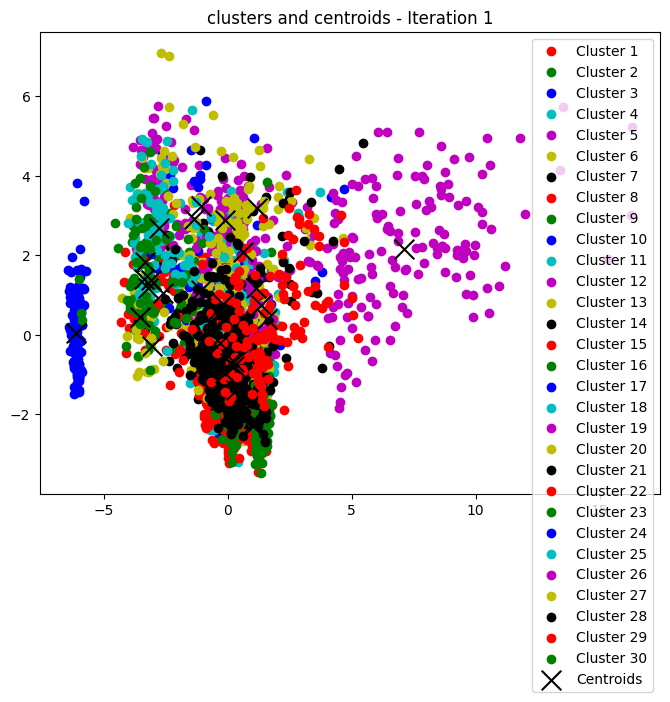

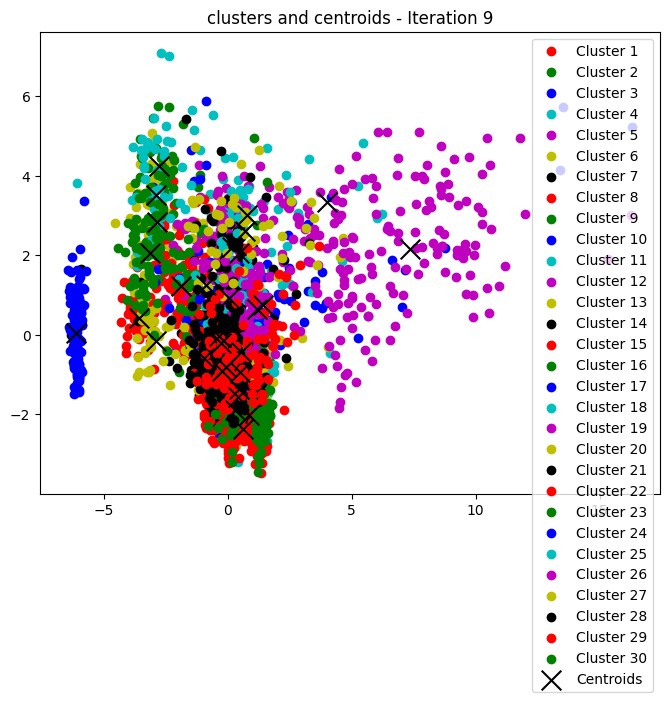

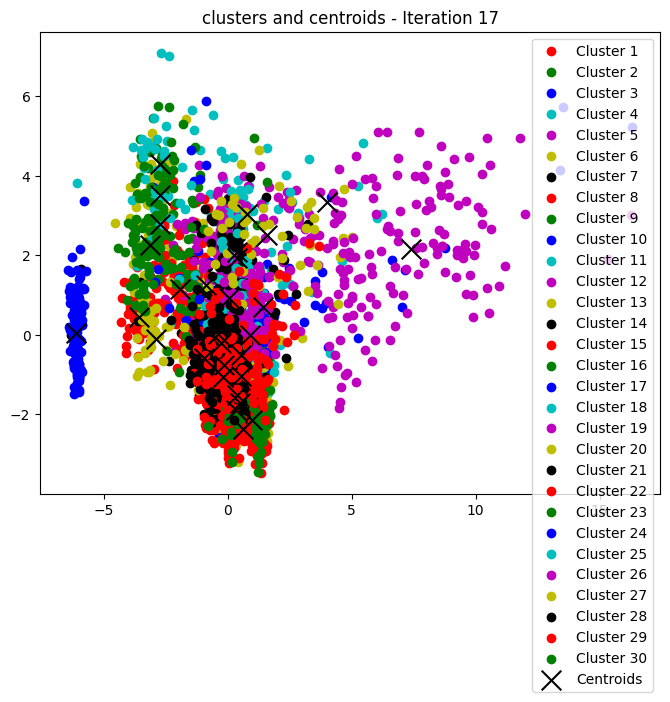

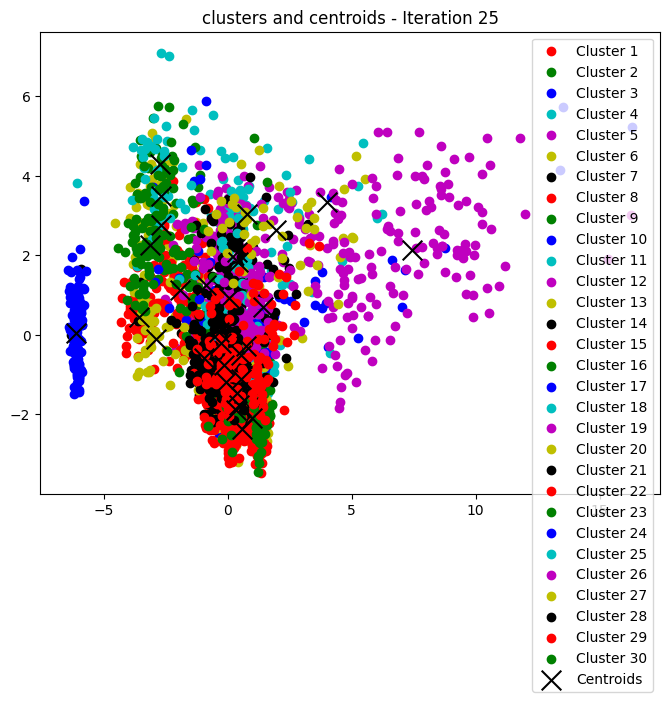

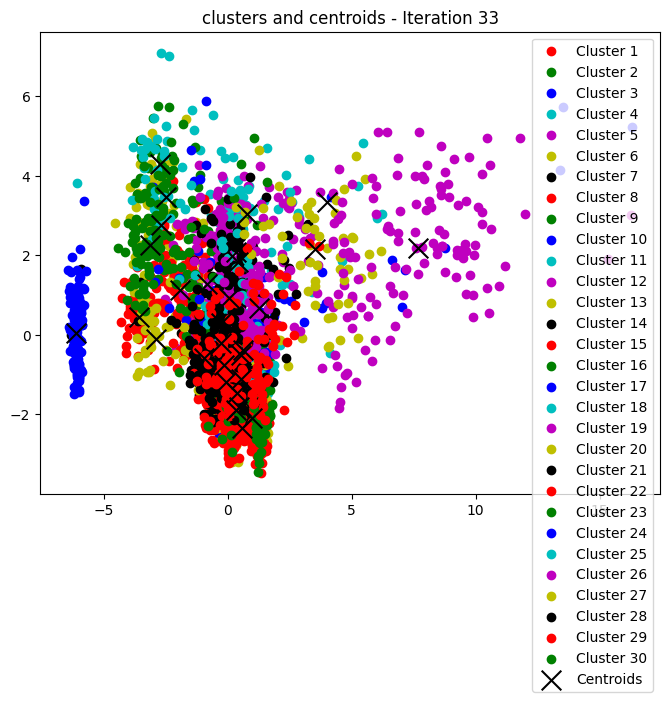

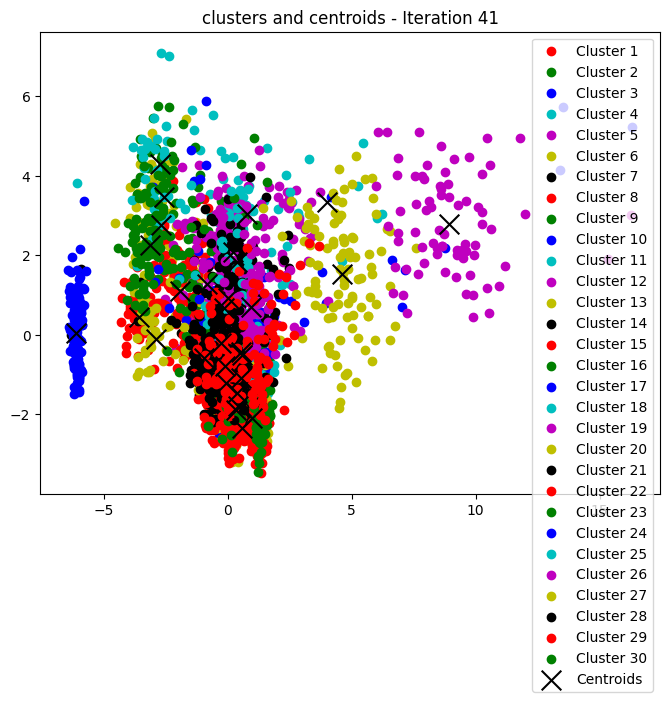

accuracy: 64.23%
F1 score: 0.46
confusion matrix:
[[250   0 191]
 [ 45   0 200]
 [ 39   0 603]]


C:\Users\Hugo\AppData\Local\Temp\ipykernel_13428\1893245688.py:11: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  most_common_label, _ = mode(int_labels[mask], axis=None)


In [14]:
#The range of k is chosen according to the size of the datasets, for most, k is tried up to 30.
highest_k = int(sqrt(X.shape[0]/2))
if highest_k < 10:
    highest_k = 10
if highest_k > 30:
    highest_k = 30
    
k_values = [i for i in range(2,highest_k+1)]
print(f'range of k values tested: [2;{highest_k}]')

#Cross-validation to find the best k
best_k = cross_validation(X_train, Y_train, k_values)
print(f"the best value of k is {best_k}")

#Centroids and cluster_labels computation using the best value of k
centroids, cluster_labels = k_means(X_train, best_k)

#Clusters labels prediction
cluster_labels = np.array([np.argmin([euclidean_distance(point, centroid) for centroid in centroids]) for point in X_test])

accuracy, f1, cm = calculate_metrics(cluster_labels, Y_test)
print(f"accuracy: {accuracy * 100:.2f}%")
print(f"F1 score: {f1:.2f}")
print(f"confusion matrix:\n{cm}")

### Wine

In [15]:
X, X_names, y, y_name = load_dataset(id = dataset_ids["wine"])
split_size = 0.7
X_train, Y_train, X_test, Y_test = preprocessing(X, y, split_size)
print(f'training set size: {X_train.shape}')
print(f'testing set size: {X_test.shape}')

data url:
 https://archive.ics.uci.edu/static/public/109/data.csv
training set size: (124, 13)
testing set size: (54, 13)


In [16]:
print_useful_data(X, X_names, y, y_name)

number of instances:  178
number of features:  13
names of the features:
 ['Alcohol' 'Malicacid' 'Ash' 'Alcalinity_of_ash' 'Magnesium'
 'Total_phenols' 'Flavanoids' 'Nonflavanoid_phenols' 'Proanthocyanins'
 'Color_intensity' 'Hue' '0D280_0D315_of_diluted_wines' 'Proline']
name of the output label:  ['class']
instance 0 feature vector:
 [1.423e+01 1.710e+00 2.430e+00 1.560e+01 1.270e+02 2.800e+00 3.060e+00
 2.800e-01 2.290e+00 5.640e+00 1.040e+00 3.920e+00 1.065e+03]
instance 0 output label:  [1]


range of k values tested: [2;10]
predicted accuracy for k=2: 61.30%


C:\Users\Hugo\AppData\Local\Temp\ipykernel_13428\1893245688.py:11: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  most_common_label, _ = mode(int_labels[mask], axis=None)


predicted accuracy for k=3: 75.73%
predicted accuracy for k=4: 92.73%
predicted accuracy for k=5: 94.40%
predicted accuracy for k=6: 93.53%
predicted accuracy for k=7: 94.33%
predicted accuracy for k=8: 95.93%
predicted accuracy for k=9: 92.77%
predicted accuracy for k=10: 99.20%
the best value of k is 10


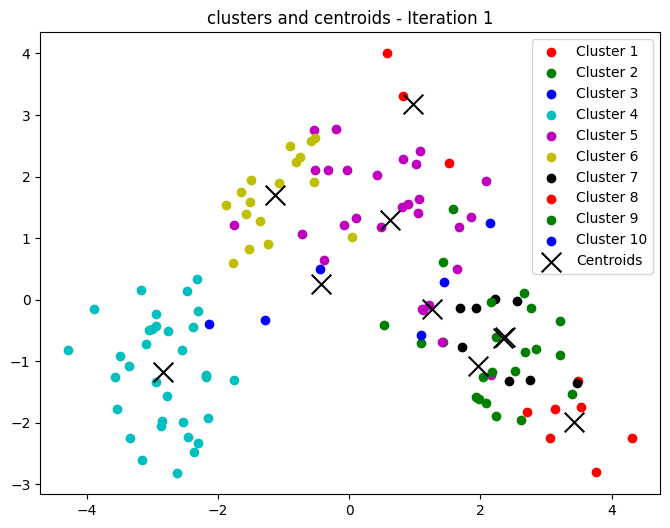

accuracy: 100.00%
F1 score: 1.00
confusion matrix:
[[19  0  0]
 [ 0 21  0]
 [ 0  0 14]]


C:\Users\Hugo\AppData\Local\Temp\ipykernel_13428\1893245688.py:11: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  most_common_label, _ = mode(int_labels[mask], axis=None)


In [17]:
#The range of k is chosen according to the size of the datasets, for most, k is tried up to 30.
highest_k = int(sqrt(X.shape[0]/2))
if highest_k < 10:
    highest_k = 10
if highest_k > 30:
    highest_k = 30
    
k_values = [i for i in range(2,highest_k+1)]
print(f'range of k values tested: [2;{highest_k}]')

#Cross-validation to find the best k
best_k = cross_validation(X_train, Y_train, k_values)
print(f"the best value of k is {best_k}")

#Centroids and cluster_labels computation using the best value of k
centroids, cluster_labels = k_means(X_train, best_k)

#Clusters labels prediction
cluster_labels = np.array([np.argmin([euclidean_distance(point, centroid) for centroid in centroids]) for point in X_test])

accuracy, f1, cm = calculate_metrics(cluster_labels, Y_test)
print(f"accuracy: {accuracy * 100:.2f}%")
print(f"F1 score: {f1:.2f}")
print(f"confusion matrix:\n{cm}")

### MAGIC gamma telescope

In [18]:
X, X_names, y, y_name = load_dataset(id = dataset_ids["magic"])
split_size = 0.7
X_train, Y_train, X_test, Y_test = preprocessing(X, y, split_size)

num_sample = 2500
X_train, X_test = X_train[:num_sample*2,:], X_test[:num_sample,:]
Y_train, Y_test = Y_train[:num_sample*2], Y_test[:num_sample]

print(f'training set size: {X_train.shape}')
print(f'testing set size: {X_test.shape}')

data url:
 https://archive.ics.uci.edu/static/public/159/data.csv
training set size: (5000, 10)
testing set size: (2500, 10)


In [19]:
print_useful_data(X, X_names, y, y_name)

number of instances:  19020
number of features:  10
names of the features:
 ['fLength' 'fWidth' 'fSize' 'fConc' 'fConc1' 'fAsym' 'fM3Long' 'fM3Trans'
 'fAlpha' 'fDist']
name of the output label:  ['class']
instance 0 feature vector:
 [28.7967 16.0021  2.6449  0.3918  0.1982 27.7004 22.011  -8.2027 40.092
 81.8828]
instance 0 output label:  ['g']


range of k values tested: [2;30]


C:\Users\Hugo\AppData\Local\Temp\ipykernel_13428\1893245688.py:11: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  most_common_label, _ = mode(int_labels[mask], axis=None)


predicted accuracy for k=2: 64.82%
predicted accuracy for k=3: 71.10%
predicted accuracy for k=4: 70.98%
predicted accuracy for k=5: 74.42%
predicted accuracy for k=6: 73.98%
predicted accuracy for k=7: 74.12%
predicted accuracy for k=8: 74.28%
predicted accuracy for k=9: 74.80%
predicted accuracy for k=10: 75.30%
predicted accuracy for k=11: 75.32%
predicted accuracy for k=12: 76.20%
predicted accuracy for k=13: 75.58%
predicted accuracy for k=14: 76.68%
predicted accuracy for k=15: 76.48%
predicted accuracy for k=16: 76.24%
predicted accuracy for k=17: 77.20%
predicted accuracy for k=18: 75.88%
predicted accuracy for k=19: 77.56%
predicted accuracy for k=20: 77.12%
predicted accuracy for k=21: 77.12%
predicted accuracy for k=22: 77.20%
predicted accuracy for k=23: 77.20%
predicted accuracy for k=24: 76.62%
predicted accuracy for k=25: 77.56%
predicted accuracy for k=26: 77.76%
predicted accuracy for k=27: 77.38%
predicted accuracy for k=28: 77.56%
predicted accuracy for k=29: 77.68%


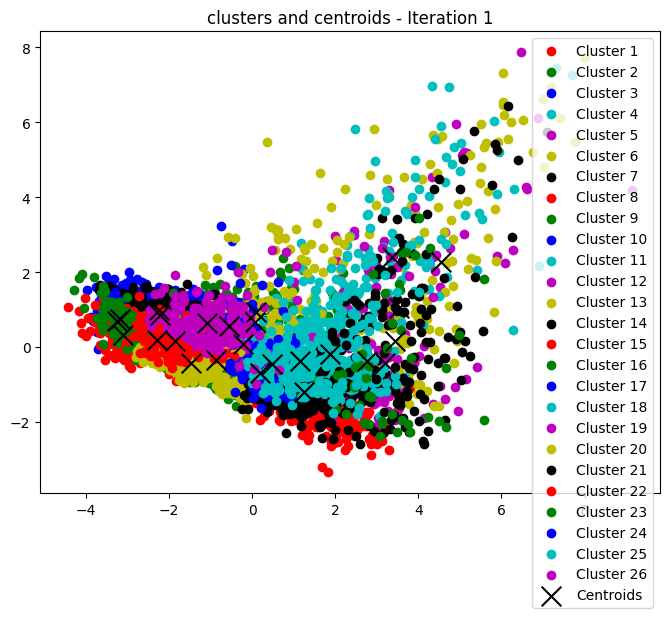

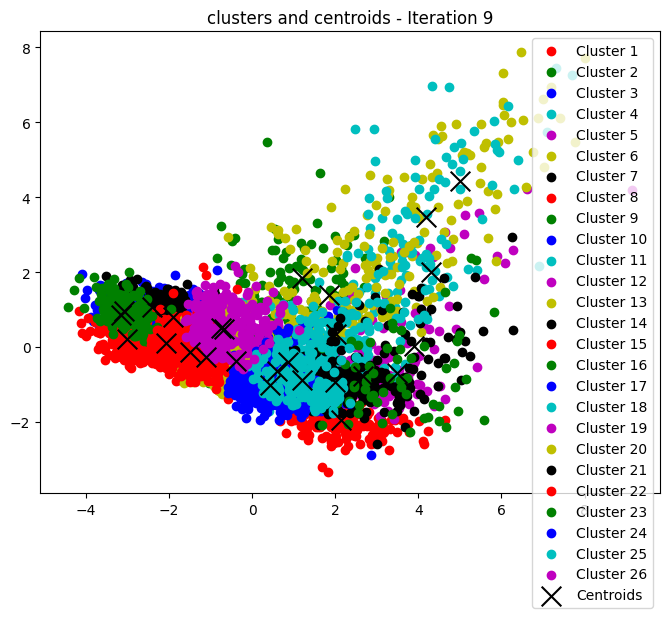

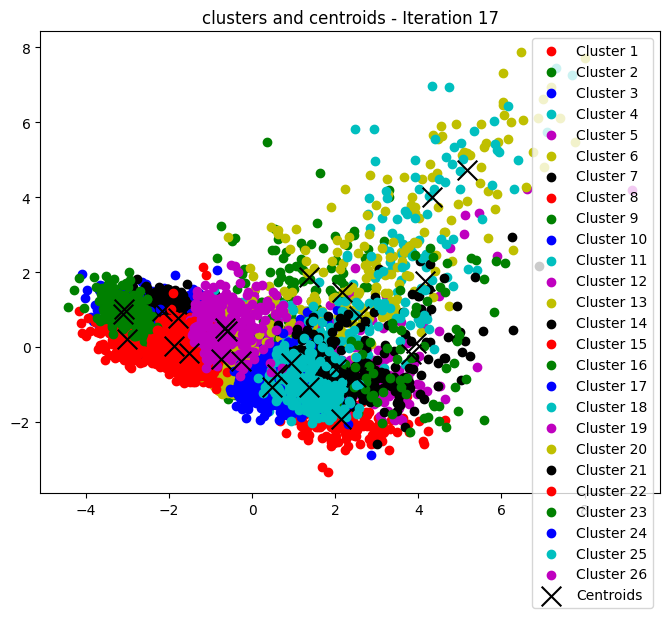

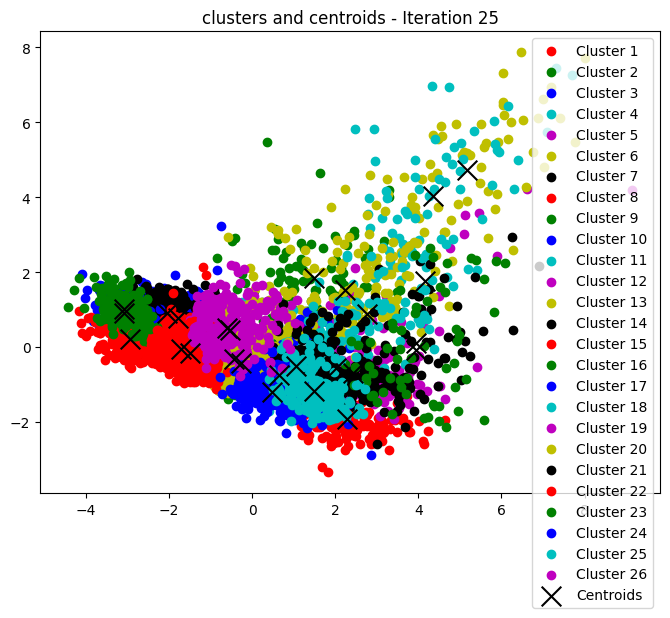

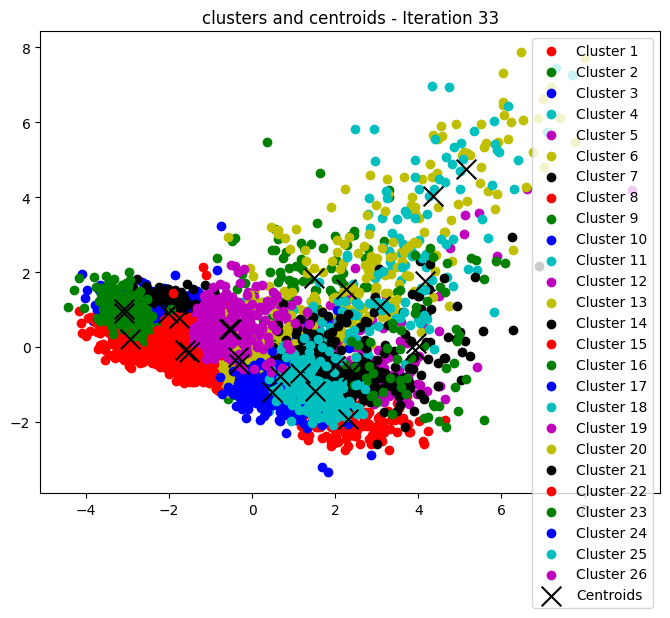

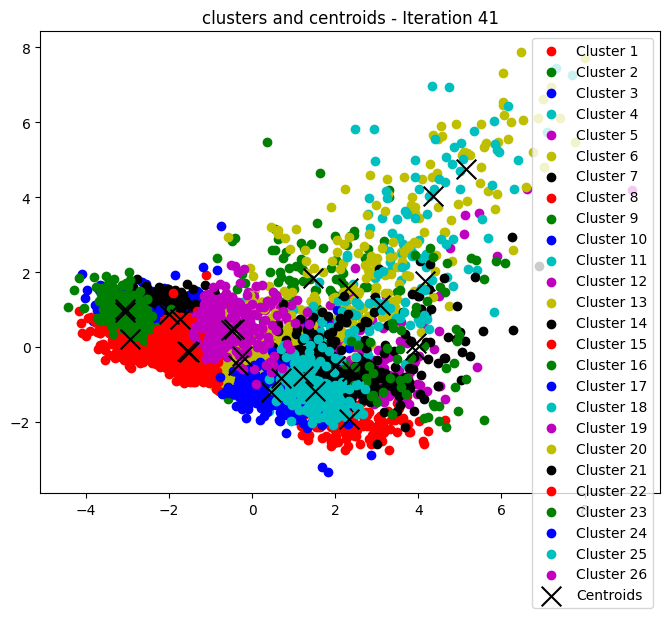

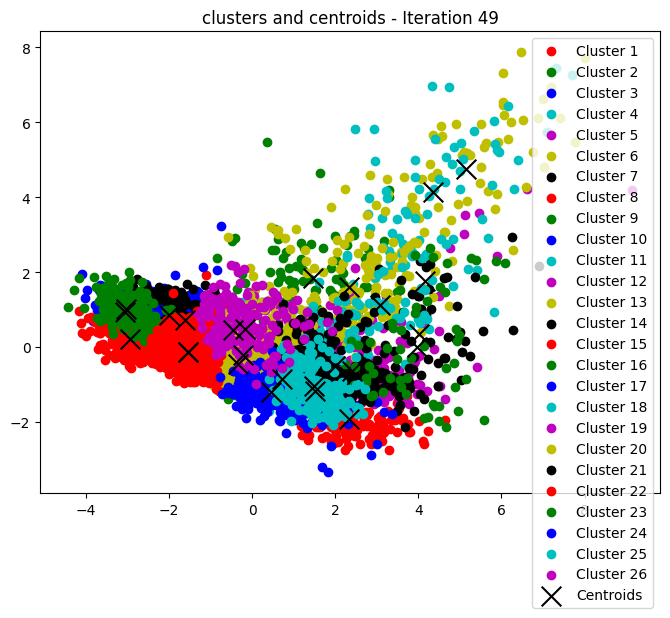

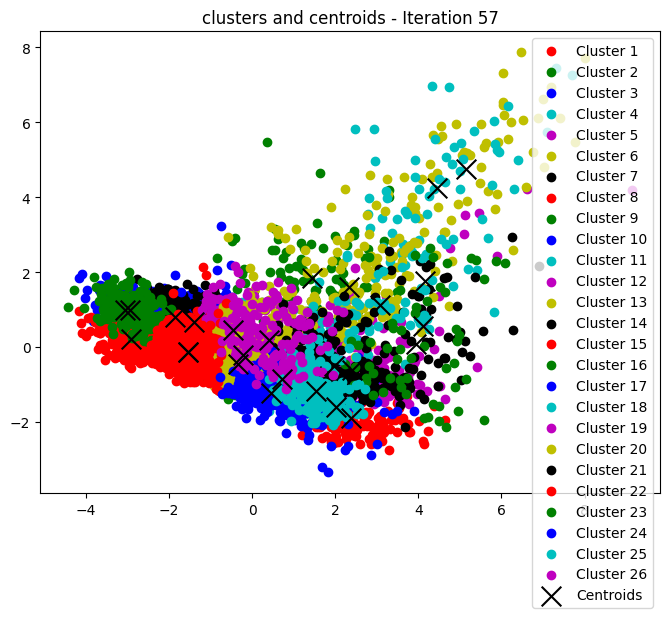

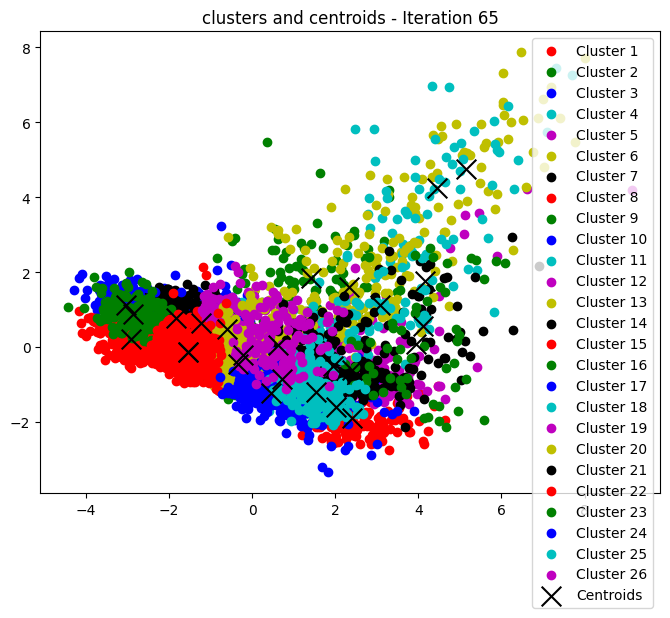

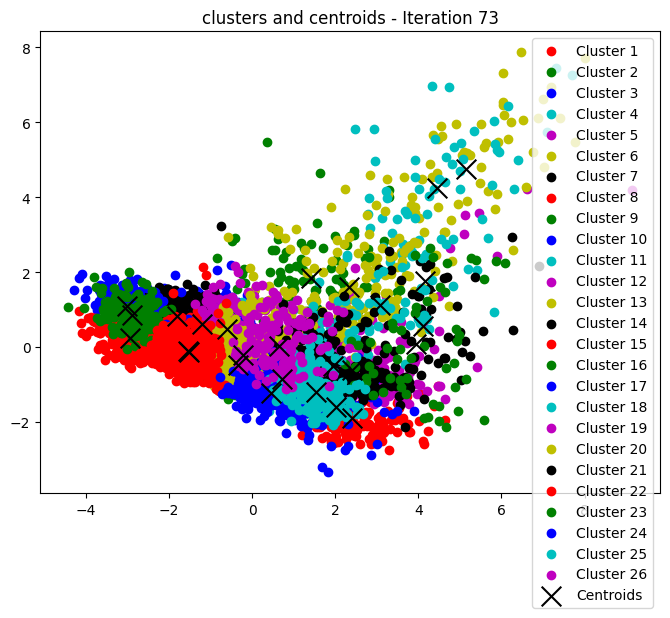

accuracy: 78.56%
F1 score: 0.74
confusion matrix:
[[1497  123]
 [ 413  467]]


C:\Users\Hugo\AppData\Local\Temp\ipykernel_13428\1893245688.py:11: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  most_common_label, _ = mode(int_labels[mask], axis=None)


In [20]:
#The range of k is chosen according to the size of the datasets, for most, k is tried up to 30.
highest_k = int(sqrt(X.shape[0]/2))
if highest_k < 10:
    highest_k = 10
if highest_k > 30:
    highest_k = 30
    
k_values = [i for i in range(2,highest_k+1)]
print(f'range of k values tested: [2;{highest_k}]')

#Cross-validation to find the best k
best_k = cross_validation(X_train, Y_train, k_values, 3)
print(f"the best value of k is {best_k}")

#Centroids and cluster_labels computation using the best value of k
centroids, cluster_labels = k_means(X_train, best_k)

#Clusters labels prediction
cluster_labels = np.array([np.argmin([euclidean_distance(point, centroid) for centroid in centroids]) for point in X_test])

accuracy, f1, cm = calculate_metrics(cluster_labels, Y_test)
print(f"accuracy: {accuracy * 100:.2f}%")
print(f"F1 score: {f1:.2f}")
print(f"confusion matrix:\n{cm}")

### Parkinsons

In [21]:
X, X_names, y, y_name = load_dataset(id = dataset_ids["parkinsons"])
split_size = 0.7
X_train, Y_train, X_test, Y_test = preprocessing(X, y, split_size)
print(f'training set size: {X_train.shape}')
print(f'testing set size: {X_test.shape}')

data url:
 https://archive.ics.uci.edu/static/public/174/data.csv
training set size: (136, 22)
testing set size: (59, 22)


In [22]:
print_useful_data(X, X_names, y, y_name)

number of instances:  195
number of features:  22
names of the features:
 ['MDVP:Fo' 'MDVP:Fhi' 'MDVP:Flo' 'MDVP:Jitter' 'MDVP:Jitter' 'MDVP:RAP'
 'MDVP:PPQ' 'Jitter:DDP' 'MDVP:Shimmer' 'MDVP:Shimmer' 'Shimmer:APQ3'
 'Shimmer:APQ5' 'MDVP:APQ' 'Shimmer:DDA' 'NHR' 'HNR' 'RPDE' 'DFA'
 'spread1' 'spread2' 'D2' 'PPE']
name of the output label:  ['status']
instance 0 feature vector:
 [ 1.199920e+02  1.573020e+02  7.499700e+01  7.840000e-03  7.840000e-03
  3.700000e-03  5.540000e-03  1.109000e-02  4.374000e-02  4.374000e-02
  2.182000e-02  3.130000e-02  2.971000e-02  6.545000e-02  2.211000e-02
  2.103300e+01  4.147830e-01  8.152850e-01 -4.813031e+00  2.664820e-01
  2.301442e+00  2.846540e-01]
instance 0 output label:  [1]


range of k values tested: [2;10]
predicted accuracy for k=2: 75.77%


C:\Users\Hugo\AppData\Local\Temp\ipykernel_13428\1893245688.py:11: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  most_common_label, _ = mode(int_labels[mask], axis=None)


predicted accuracy for k=3: 77.99%
predicted accuracy for k=4: 82.43%
predicted accuracy for k=5: 82.41%
predicted accuracy for k=6: 83.15%
predicted accuracy for k=7: 88.25%
predicted accuracy for k=8: 86.77%
predicted accuracy for k=9: 86.06%
predicted accuracy for k=10: 88.99%
the best value of k is 10


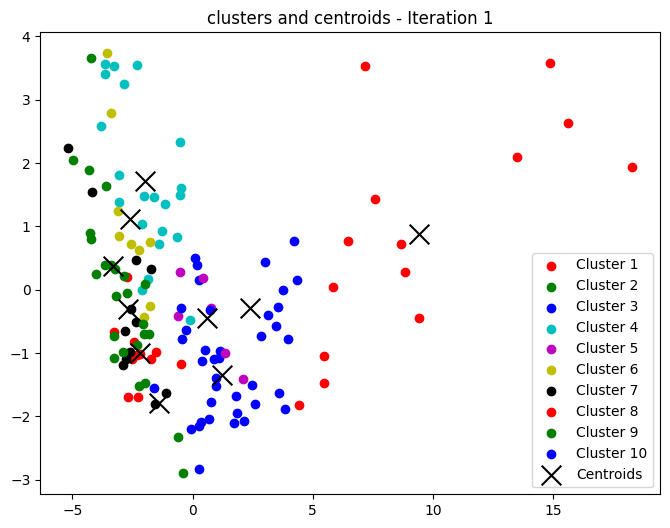

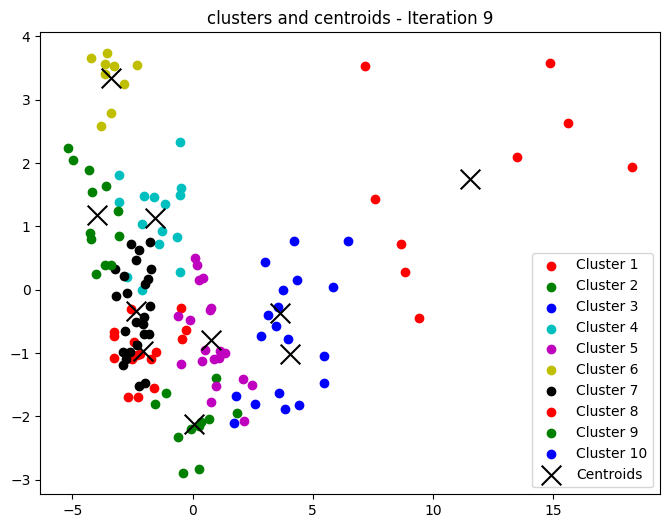

accuracy: 84.75%
F1 score: 0.77
confusion matrix:
[[ 8  7]
 [ 2 42]]


C:\Users\Hugo\AppData\Local\Temp\ipykernel_13428\1893245688.py:11: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  most_common_label, _ = mode(int_labels[mask], axis=None)


In [23]:
#The range of k is chosen according to the size of the datasets, for most, k is tried up to 30.
highest_k = int(sqrt(X.shape[0]/2))
if highest_k < 10:
    highest_k = 10
if highest_k > 30:
    highest_k = 30
    
k_values = [i for i in range(2,highest_k+1)]
print(f'range of k values tested: [2;{highest_k}]')

#Cross-validation to find the best k
best_k = cross_validation(X_train, Y_train, k_values)
print(f"the best value of k is {best_k}")

#Centroids and cluster_labels computation using the best value of k
centroids, cluster_labels = k_means(X_train, best_k)

#Clusters labels prediction
cluster_labels = np.array([np.argmin([euclidean_distance(point, centroid) for centroid in centroids]) for point in X_test])

accuracy, f1, cm = calculate_metrics(cluster_labels, Y_test)
print(f"accuracy: {accuracy * 100:.2f}%")
print(f"F1 score: {f1:.2f}")
print(f"confusion matrix:\n{cm}")

### Page-blocks

In [24]:
X, X_names, y, y_name = load_dataset(id = dataset_ids["page-blocks"])
split_size = 0.7
X_train, Y_train, X_test, Y_test = preprocessing(X, y, split_size)
print(f'training set size: {X_train.shape}')
print(f'testing set size: {X_test.shape}')

data url:
 https://archive.ics.uci.edu/static/public/78/data.csv
training set size: (3831, 10)
testing set size: (1642, 10)


In [25]:
print_useful_data(X, X_names, y, y_name)

number of instances:  5473
number of features:  10
names of the features:
 ['height' 'length' 'area' 'eccen' 'p_black' 'p_and' 'mean_tr' 'blackpix'
 'blackand' 'wb_trans']
name of the output label:  ['class']
instance 0 feature vector:
 [ 5.     7.    35.     1.4    0.4    0.657  2.33  14.    23.     6.   ]
instance 0 output label:  [1]


range of k values tested: [2;30]


C:\Users\Hugo\AppData\Local\Temp\ipykernel_13428\1893245688.py:11: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  most_common_label, _ = mode(int_labels[mask], axis=None)


predicted accuracy for k=2: 89.98%
predicted accuracy for k=3: 90.03%
predicted accuracy for k=4: 90.81%
predicted accuracy for k=5: 91.44%
predicted accuracy for k=6: 91.33%
predicted accuracy for k=7: 91.57%
predicted accuracy for k=8: 91.86%
predicted accuracy for k=9: 92.04%
predicted accuracy for k=10: 92.40%
predicted accuracy for k=11: 92.30%
predicted accuracy for k=12: 92.40%
predicted accuracy for k=13: 92.51%
predicted accuracy for k=14: 92.59%
predicted accuracy for k=15: 92.64%
predicted accuracy for k=16: 92.82%
predicted accuracy for k=17: 92.61%
predicted accuracy for k=18: 93.03%
predicted accuracy for k=19: 92.80%
predicted accuracy for k=20: 92.95%
predicted accuracy for k=21: 93.03%
predicted accuracy for k=22: 93.29%
predicted accuracy for k=23: 93.03%
predicted accuracy for k=24: 92.98%
predicted accuracy for k=25: 93.19%
predicted accuracy for k=26: 93.29%
predicted accuracy for k=27: 93.37%
predicted accuracy for k=28: 93.34%
predicted accuracy for k=29: 93.21%


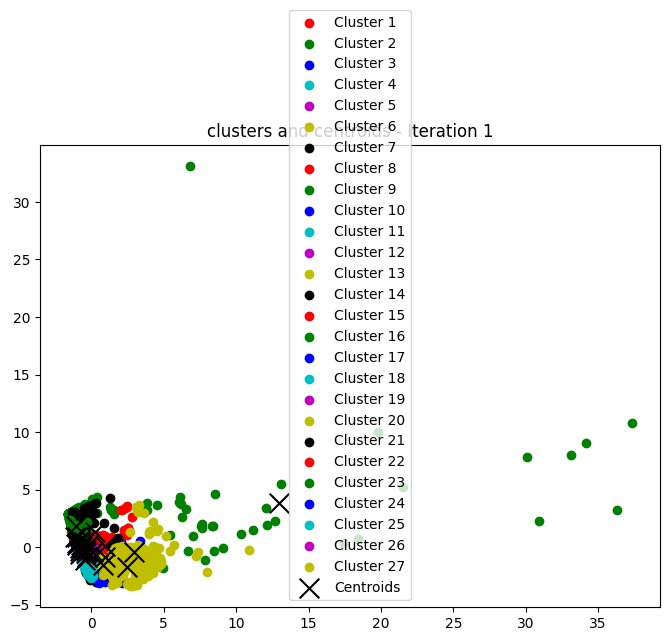

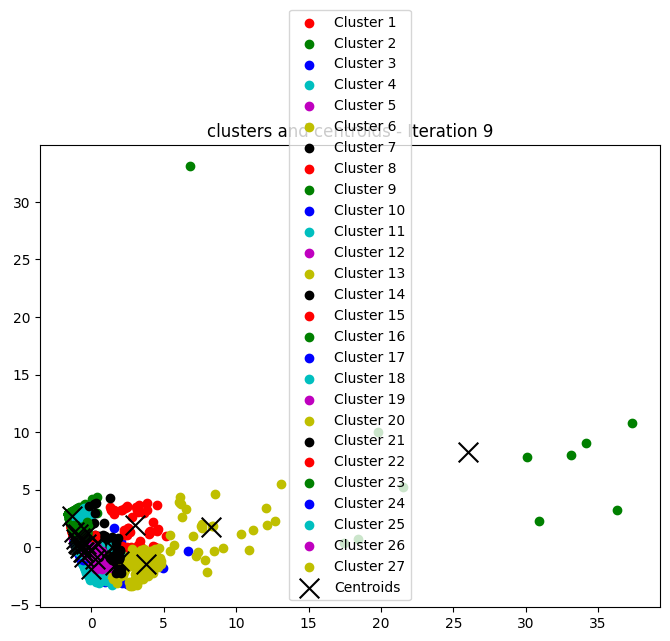

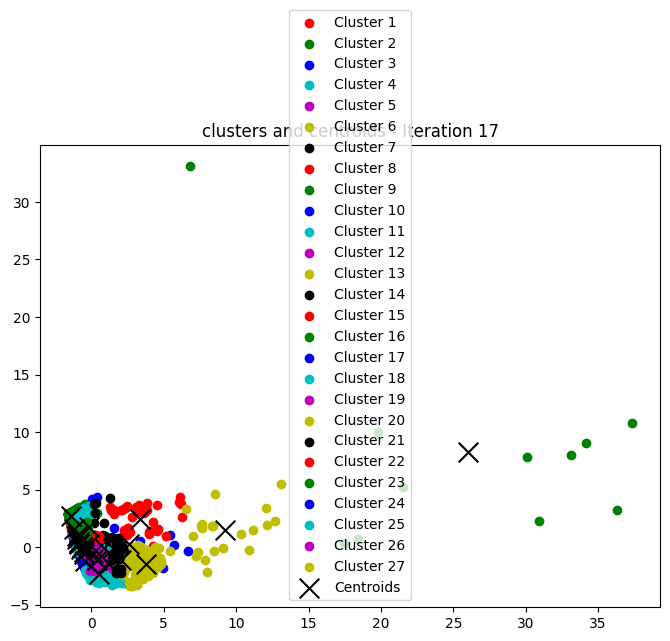

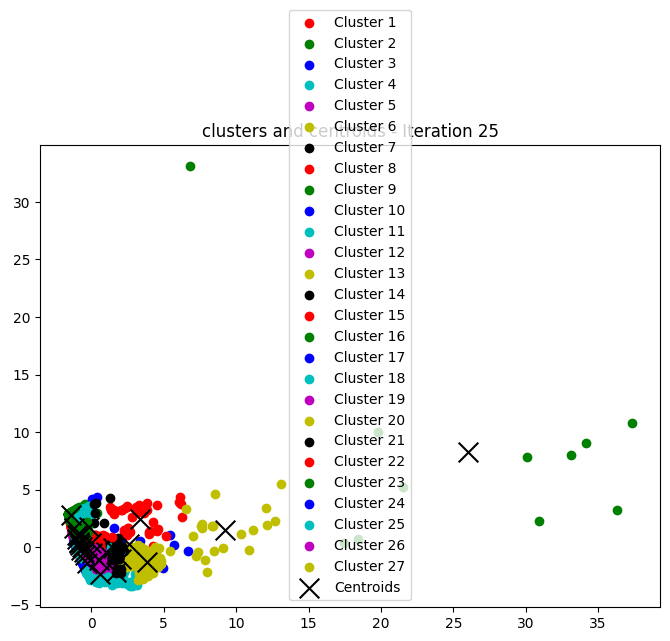

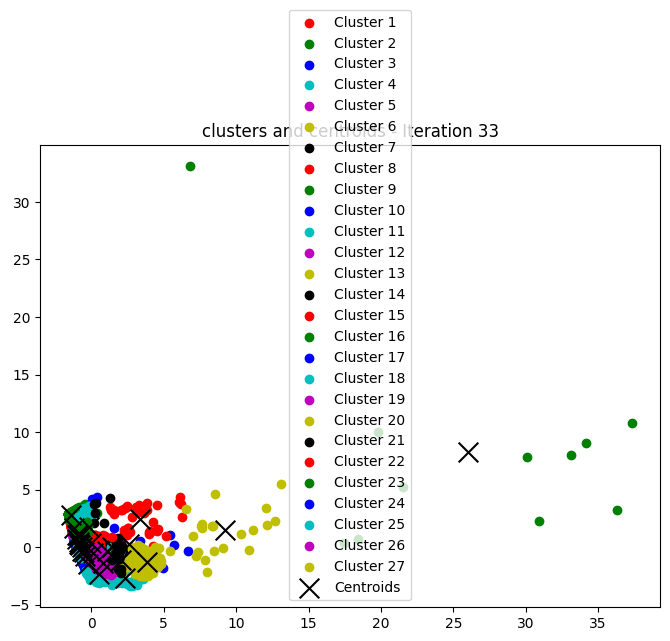

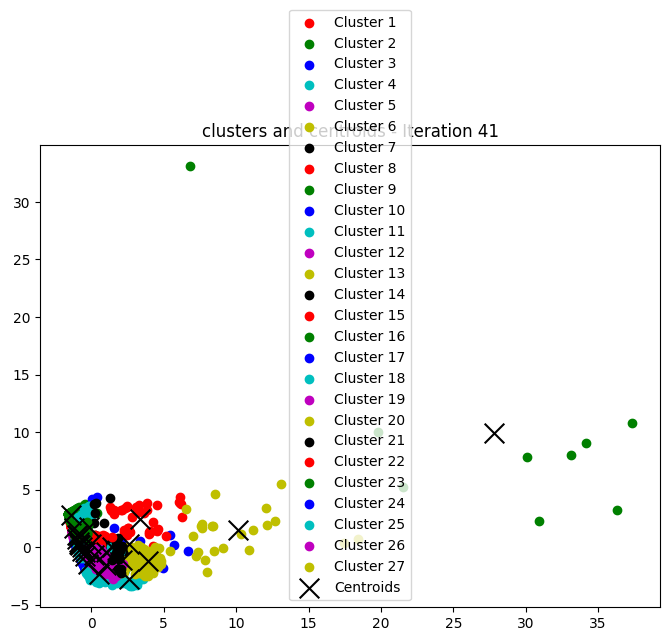

accuracy: 92.57%
F1 score: 0.39
confusion matrix:
[[1457    6    0    3    0]
 [  48   58    0    0    0]
 [   7    0    1    2    0]
 [   7   20    0    4    0]
 [  27    0    1    1    0]]


C:\Users\Hugo\AppData\Local\Temp\ipykernel_13428\1893245688.py:11: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  most_common_label, _ = mode(int_labels[mask], axis=None)


In [26]:
#The range of k is chosen according to the size of the datasets, for most, k is tried up to 30.
highest_k = int(sqrt(X.shape[0]/2))
if highest_k < 10:
    highest_k = 10
if highest_k > 30:
    highest_k = 30
    
k_values = [i for i in range(2,highest_k+1)]
print(f'range of k values tested: [2;{highest_k}]')

#Cross-validation to find the best k
best_k = cross_validation(X_train, Y_train, k_values)
print(f"the best value of k is {best_k}")

#Centroids and cluster_labels computation using the best value of k
centroids, cluster_labels = k_means(X_train, best_k)

#Clusters labels prediction
cluster_labels = np.array([np.argmin([euclidean_distance(point, centroid) for centroid in centroids]) for point in X_test])

accuracy, f1, cm = calculate_metrics(cluster_labels, Y_test)
print(f"accuracy: {accuracy * 100:.2f}%")
print(f"F1 score: {f1:.2f}")
print(f"confusion matrix:\n{cm}")

### Optical

In [27]:
X, X_names, y, y_name = load_dataset(id = dataset_ids["optical"])
split_size = 0.7
X_train, Y_train, X_test, Y_test = preprocessing(X, y, split_size)

print(f'training set size: {X_train.shape}')
print(f'testing set size: {X_test.shape}')

data url:
 https://archive.ics.uci.edu/static/public/80/data.csv
training set size: (3933, 64)
testing set size: (1687, 64)


In [28]:
print_useful_data(X, X_names, y, y_name)

number of instances:  5620
number of features:  64
names of the features:
 ['Attribute1' 'Attribute2' 'Attribute3' 'Attribute4' 'Attribute5'
 'Attribute6' 'Attribute7' 'Attribute8' 'Attribute9' 'Attribute10'
 'Attribute11' 'Attribute12' 'Attribute13' 'Attribute14' 'Attribute15'
 'Attribute16' 'Attribute17' 'Attribute18' 'Attribute19' 'Attribute20'
 'Attribute21' 'Attribute22' 'Attribute23' 'Attribute24' 'Attribute25'
 'Attribute26' 'Attribute27' 'Attribute28' 'Attribute29' 'Attribute30'
 'Attribute31' 'Attribute32' 'Attribute33' 'Attribute34' 'Attribute35'
 'Attribute36' 'Attribute37' 'Attribute38' 'Attribute39' 'Attribute40'
 'Attribute41' 'Attribute42' 'Attribute43' 'Attribute44' 'Attribute45'
 'Attribute46' 'Attribute47' 'Attribute48' 'Attribute49' 'Attribute50'
 'Attribute51' 'Attribute52' 'Attribute53' 'Attribute54' 'Attribute55'
 'Attribute56' 'Attribute57' 'Attribute58' 'Attribute59' 'Attribute60'
 'Attribute61' 'Attribute62' 'Attribute63' 'Attribute64']
name of the output label

range of k values tested: [2;30]


C:\Users\Hugo\AppData\Local\Temp\ipykernel_13428\1893245688.py:11: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  most_common_label, _ = mode(int_labels[mask], axis=None)


predicted accuracy for k=2: 21.03%
predicted accuracy for k=3: 30.16%
predicted accuracy for k=4: 33.28%
predicted accuracy for k=5: 45.64%
predicted accuracy for k=6: 49.63%
predicted accuracy for k=7: 56.32%
predicted accuracy for k=8: 61.78%
predicted accuracy for k=9: 62.06%
predicted accuracy for k=10: 68.37%
predicted accuracy for k=11: 69.06%
predicted accuracy for k=12: 71.60%
predicted accuracy for k=13: 79.97%
predicted accuracy for k=14: 81.13%
predicted accuracy for k=15: 83.12%
predicted accuracy for k=16: 81.11%
predicted accuracy for k=17: 83.52%
predicted accuracy for k=18: 83.96%
predicted accuracy for k=19: 85.20%
predicted accuracy for k=20: 85.18%
predicted accuracy for k=21: 85.94%
predicted accuracy for k=22: 84.31%
predicted accuracy for k=23: 85.86%
predicted accuracy for k=24: 87.18%
predicted accuracy for k=25: 87.72%
predicted accuracy for k=26: 86.85%
predicted accuracy for k=27: 87.41%
predicted accuracy for k=28: 87.74%
predicted accuracy for k=29: 87.21%


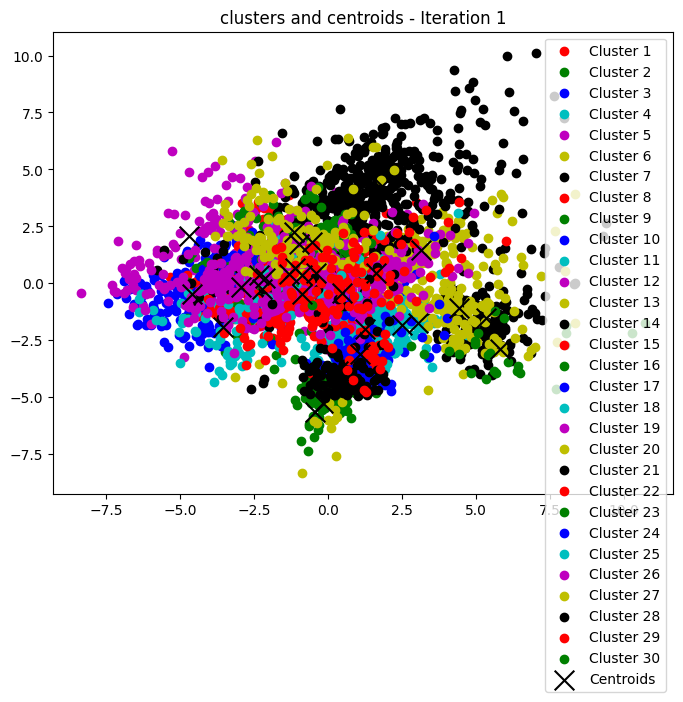

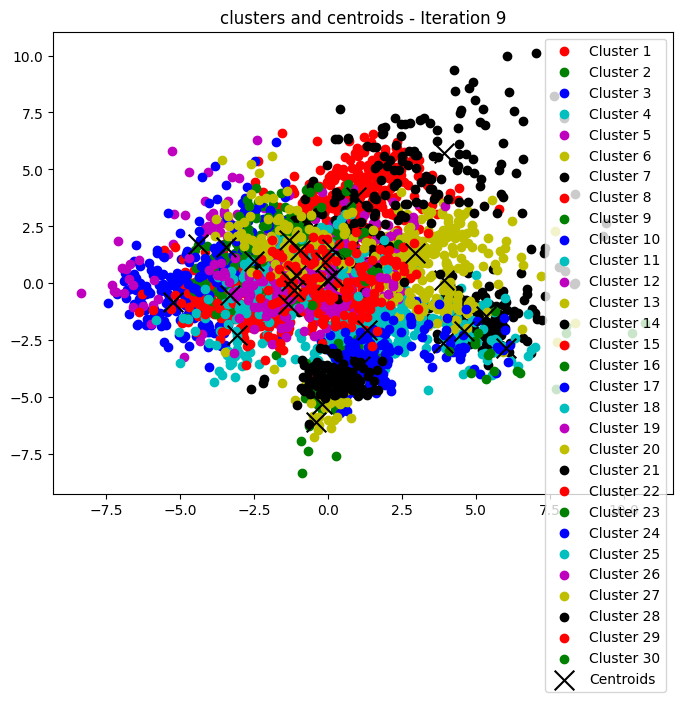

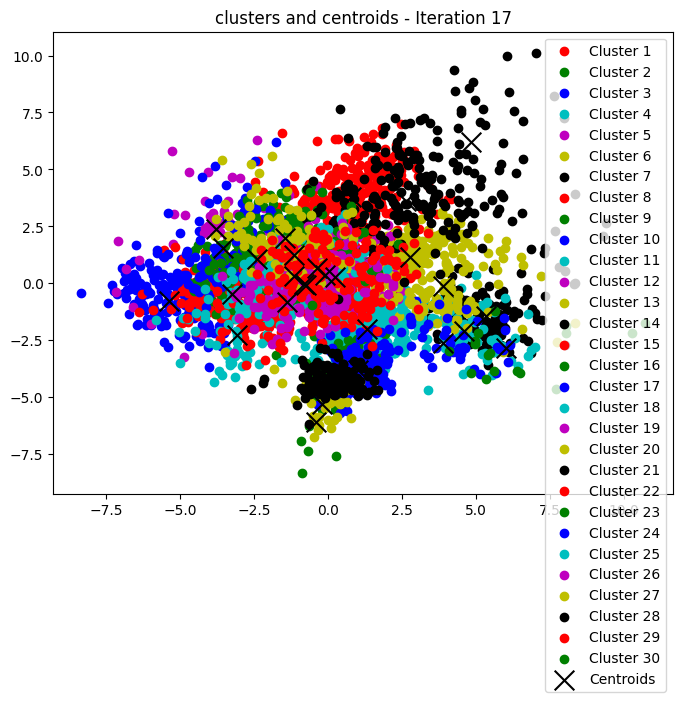

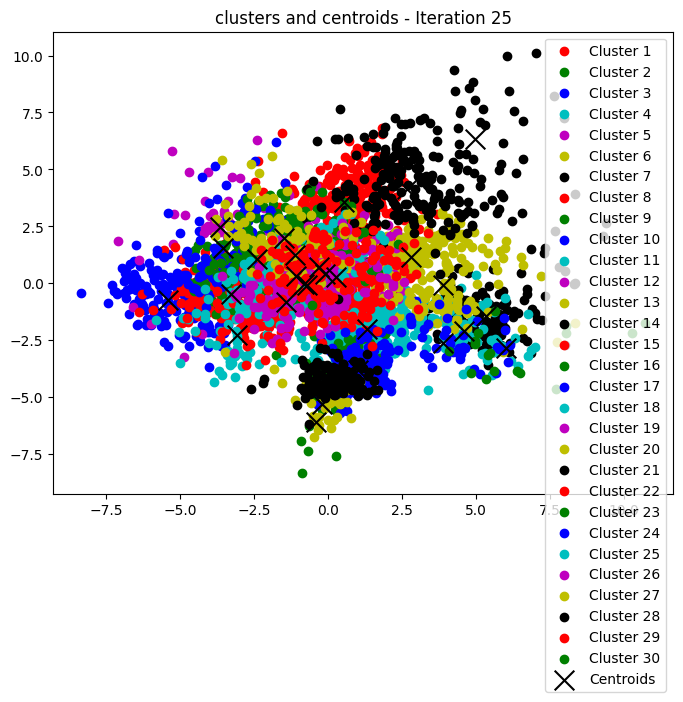

accuracy: 87.08%
F1 score: 0.87
confusion matrix:
[[167   1   0   1   0   0   1   0   0   0]
 [  0 167   1   0   0   0   2   0   2   1]
 [  0  14 110   0   1   0   1   6  21   1]
 [  0   1   0 140   0   4   0   9   9  10]
 [  0   2   0   0 164   0   2  12   3   0]
 [  0   1   0   2   1 133   0  10   1   5]
 [  0   1   0   0   0   0 167   0   0   0]
 [  0   4   0   1   0   1   0 180   0   0]
 [  0  10   1   3   0   1   0   2 134   2]
 [  0  10   0   7   0   4   0  40   6 107]]


C:\Users\Hugo\AppData\Local\Temp\ipykernel_13428\1893245688.py:11: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  most_common_label, _ = mode(int_labels[mask], axis=None)


In [29]:
#The range of k is chosen according to the size of the datasets, for most, k is tried up to 30.
highest_k = int(sqrt(X.shape[0]/2))
if highest_k < 10:
    highest_k = 10
if highest_k > 30:
    highest_k = 30
    
k_values = [i for i in range(2,highest_k+1)]
print(f'range of k values tested: [2;{highest_k}]')

#Cross-validation to find the best k
best_k = cross_validation(X_train, Y_train, k_values)
print(f"the best value of k is {best_k}")

#Centroids and cluster_labels computation using the best value of k
centroids, cluster_labels = k_means(X_train, best_k)

#Clusters labels prediction
cluster_labels = np.array([np.argmin([euclidean_distance(point, centroid) for centroid in centroids]) for point in X_test])

accuracy, f1, cm = calculate_metrics(cluster_labels, Y_test)
print(f"accuracy: {accuracy * 100:.2f}%")
print(f"F1 score: {f1:.2f}")
print(f"confusion matrix:\n{cm}")

### Ionosphere

In [30]:
X, X_names, y, y_name = load_dataset(id = dataset_ids["ionosphere"])
split_size = 0.7
X_train, Y_train, X_test, Y_test = preprocessing(X, y, split_size)
print(f'training set size: {X_train.shape}')
print(f'testing set size: {X_test.shape}')

data url:
 https://archive.ics.uci.edu/static/public/52/data.csv
training set size: (245, 34)
testing set size: (106, 34)


In [31]:
print_useful_data(X, X_names, y, y_name)

number of instances:  351
number of features:  34
names of the features:
 ['Attribute1' 'Attribute2' 'Attribute3' 'Attribute4' 'Attribute5'
 'Attribute6' 'Attribute7' 'Attribute8' 'Attribute9' 'Attribute10'
 'Attribute11' 'Attribute12' 'Attribute13' 'Attribute14' 'Attribute15'
 'Attribute16' 'Attribute17' 'Attribute18' 'Attribute19' 'Attribute20'
 'Attribute21' 'Attribute22' 'Attribute23' 'Attribute24' 'Attribute25'
 'Attribute26' 'Attribute27' 'Attribute28' 'Attribute29' 'Attribute30'
 'Attribute31' 'Attribute32' 'Attribute33' 'Attribute34']
name of the output label:  ['Class']
instance 0 feature vector:
 [ 1.       0.       0.99539 -0.05889  0.85243  0.02306  0.83398 -0.37708
  1.       0.0376   0.85243 -0.17755  0.59755 -0.44945  0.60536 -0.38223
  0.84356 -0.38542  0.58212 -0.32192  0.56971 -0.29674  0.36946 -0.47357
  0.56811 -0.51171  0.41078 -0.46168  0.21266 -0.3409   0.42267 -0.54487
  0.18641 -0.453  ]
instance 0 output label:  ['g']


range of k values tested: [2;13]


C:\Users\Hugo\AppData\Local\Temp\ipykernel_13428\1893245688.py:11: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  most_common_label, _ = mode(int_labels[mask], axis=None)


predicted accuracy for k=2: 70.20%
predicted accuracy for k=3: 74.29%
predicted accuracy for k=4: 77.55%
predicted accuracy for k=5: 74.29%
predicted accuracy for k=6: 80.00%
predicted accuracy for k=7: 80.41%
predicted accuracy for k=8: 83.67%
predicted accuracy for k=9: 84.08%
predicted accuracy for k=10: 84.49%
predicted accuracy for k=11: 84.90%
predicted accuracy for k=12: 82.04%
predicted accuracy for k=13: 83.67%
the best value of k is 11


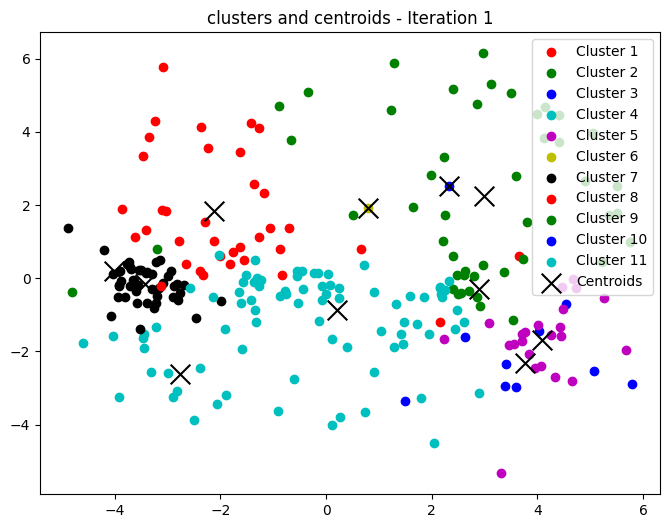

accuracy: 85.85%
F1 score: 0.84
confusion matrix:
[[27 12]
 [ 3 64]]


C:\Users\Hugo\AppData\Local\Temp\ipykernel_13428\1893245688.py:11: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  most_common_label, _ = mode(int_labels[mask], axis=None)


In [32]:
#The range of k is chosen according to the size of the datasets, for most, k is tried up to 30.
highest_k = int(sqrt(X.shape[0]/2))
if highest_k < 10:
    highest_k = 10
if highest_k > 30:
    highest_k = 30
    
k_values = [i for i in range(2,highest_k+1)]
print(f'range of k values tested: [2;{highest_k}]')

#Cross-validation to find the best k
best_k = cross_validation(X_train, Y_train, k_values)
print(f"the best value of k is {best_k}")

#Centroids and cluster_labels computation using the best value of k
centroids, cluster_labels = k_means(X_train, best_k)

#Clusters labels prediction
cluster_labels = np.array([np.argmin([euclidean_distance(point, centroid) for centroid in centroids]) for point in X_test])

accuracy, f1, cm = calculate_metrics(cluster_labels, Y_test)
print(f"accuracy: {accuracy * 100:.2f}%")
print(f"F1 score: {f1:.2f}")
print(f"confusion matrix:\n{cm}")

### Glass Identification

In [33]:
X, X_names, y, y_name = load_dataset(id = dataset_ids["glass"])
split_size = 0.7
X_train, Y_train, X_test, Y_test = preprocessing(X, y, split_size)
print(f'training set size: {X_train.shape}')
print(f'testing set size: {X_test.shape}')

data url:
 https://archive.ics.uci.edu/static/public/42/data.csv
training set size: (149, 9)
testing set size: (65, 9)


In [34]:
print_useful_data(X, X_names, y, y_name)

number of instances:  214
number of features:  9
names of the features:
 ['RI' 'Na' 'Mg' 'Al' 'Si' 'K' 'Ca' 'Ba' 'Fe']
name of the output label:  ['Type_of_glass']
instance 0 feature vector:
 [1.52101e+00 1.36400e+01 4.49000e+00 1.10000e+00 7.17800e+01 6.00000e-02
 8.75000e+00 0.00000e+00 0.00000e+00]
instance 0 output label:  [1]


range of k values tested: [2;10]
predicted accuracy for k=2: 40.23%


C:\Users\Hugo\AppData\Local\Temp\ipykernel_13428\1893245688.py:11: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  most_common_label, _ = mode(int_labels[mask], axis=None)


predicted accuracy for k=3: 48.25%
predicted accuracy for k=4: 52.32%
predicted accuracy for k=5: 56.99%
predicted accuracy for k=6: 59.01%
predicted accuracy for k=7: 59.01%
predicted accuracy for k=8: 60.34%
predicted accuracy for k=9: 60.37%
predicted accuracy for k=10: 67.06%
the best value of k is 10


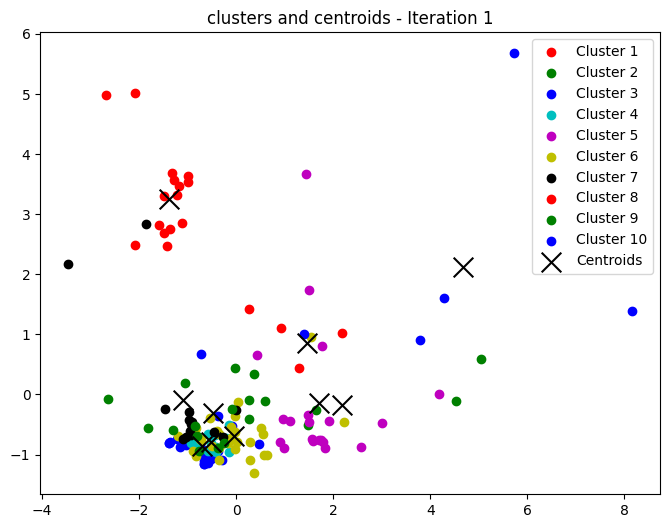

accuracy: 58.46%
F1 score: 0.43
confusion matrix:
[[ 5 14  0  0  0  0]
 [ 2 20  0  1  0  0]
 [ 0  4  0  0  0  0]
 [ 0  2  0  4  0  0]
 [ 1  0  0  1  0  1]
 [ 0  1  0  0  0  9]]


C:\Users\Hugo\AppData\Local\Temp\ipykernel_13428\1893245688.py:11: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  most_common_label, _ = mode(int_labels[mask], axis=None)


In [35]:
#The range of k is chosen according to the size of the datasets, for most, k is tried up to 30.
highest_k = int(sqrt(X.shape[0]/2))
if highest_k < 10:
    highest_k = 10
if highest_k > 30:
    highest_k = 30
    
k_values = [i for i in range(2,highest_k+1)]
print(f'range of k values tested: [2;{highest_k}]')

#Cross-validation to find the best k
best_k = cross_validation(X_train, Y_train, k_values)
print(f"the best value of k is {best_k}")

#Centroids and cluster_labels computation using the best value of k
centroids, cluster_labels = k_means(X_train, best_k)

#Clusters labels prediction
cluster_labels = np.array([np.argmin([euclidean_distance(point, centroid) for centroid in centroids]) for point in X_test])

accuracy, f1, cm = calculate_metrics(cluster_labels, Y_test)
print(f"accuracy: {accuracy * 100:.2f}%")
print(f"F1 score: {f1:.2f}")
print(f"confusion matrix:\n{cm}")

### Letter Recognition

In [36]:
X, X_names, y, y_name = load_dataset(id = dataset_ids["letter"])
split_size = 0.7
X_train, Y_train, X_test, Y_test = preprocessing(X, y, split_size)
print(f'training set size: {X_train.shape}')
print(f'testing set size: {X_test.shape}')

data url:
 https://archive.ics.uci.edu/static/public/59/data.csv
training set size: (14000, 16)
testing set size: (6000, 16)


In [37]:
print_useful_data(X, X_names, y, y_name)

number of instances:  20000
number of features:  16
names of the features:
 ['x-box' 'y-box' 'width' 'high' 'onpix' 'x-bar' 'y-bar' 'x2bar' 'y2bar'
 'xybar' 'x2ybr' 'xy2br' 'x-ege' 'xegvy' 'y-ege' 'yegvx']
name of the output label:  ['lettr']
instance 0 feature vector:
 [ 2  8  3  5  1  8 13  0  6  6 10  8  0  8  0  8]
instance 0 output label:  ['T']


In [38]:
k = 600 #After testing a few values for this complex dataset, the best value of k is much higher than 30 (30 gives around 30% accuracy). k higher than 600 could increase accuracy but also lead to overfitting.
#Centroids and cluster_labels computation using the best value of k
centroids, cluster_labels = k_means(X_train, k, visualization = False)

#Clusters labels prediction
cluster_labels = np.array([np.argmin([euclidean_distance(point, centroid) for centroid in centroids]) for point in X_test])

accuracy, f1, cm = calculate_metrics(cluster_labels, Y_test)
print(f"accuracy: {accuracy * 100:.2f}%")
print(f"F1 score: {f1:.2f}")
print(f"confusion matrix:\n{cm}")

accuracy: 80.65%
F1 score: 0.81
confusion matrix:
[[217   0   0   0   0   0   1   2   1   0   0   0   3   0   0   0   0   0
    1   0   3   0   0   0   1   3]
 [  0 184   0   6   6   1   2   3   0   2   0   0   0   2   0   1   0  11
    5   1   2   0   0   1   1   1]
 [  0   0 173   0  12   2   2   1   0   0   0   0   2   0   2   1   1   0
    1   2   1   0   1   0   0   0]
 [  2  11   0 192   0   1   0   7   1   4   0   0   0   1   4   0   0   8
   14   0   1   0   0   4   0   0]
 [  0   2  10   0 179   4   1   2   0   0   9   1   0   0   0   0   2   0
    7   0   0   0   0  16   0   5]
 [  0   1   1   2   4 151   1   2   1   1   0   0   0   2   0  35   0   0
    0   9   0   0   1   0   0   0]
 [  0   6   7   0   4   0 193   3   0   0   3   0   0   0   1   0   2   1
    7   0   0   0   3   0   0   0]
 [  0  11   1  11   2   2  12 121   1   1  15   0   0   2   9   1   1   8
    6   0   0   0   0   8   5   1]
 [  0   0   0   0   1   2   2   0 201   8   0   0   0   0   0   0   0   0
    

C:\Users\Hugo\AppData\Local\Temp\ipykernel_13428\1893245688.py:11: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  most_common_label, _ = mode(int_labels[mask], axis=None)


### Connectionist Bench (Sonar, Mines vs. Rocks)

In [39]:
X, X_names, y, y_name = load_dataset(id = dataset_ids["conn-bench-sonar"])
split_size = 0.7
X_train, Y_train, X_test, Y_test = preprocessing(X, y, split_size)
print(f'training set size: {X_train.shape}')
print(f'testing set size: {X_test.shape}')

data url:
 https://archive.ics.uci.edu/static/public/151/data.csv
training set size: (145, 60)
testing set size: (63, 60)


In [40]:
print_useful_data(X, X_names, y, y_name)

number of instances:  208
number of features:  60
names of the features:
 ['Attribute1' 'Attribute2' 'Attribute3' 'Attribute4' 'Attribute5'
 'Attribute6' 'Attribute7' 'Attribute8' 'Attribute9' 'Attribute10'
 'Attribute11' 'Attribute12' 'Attribute13' 'Attribute14' 'Attribute15'
 'Attribute16' 'Attribute17' 'Attribute18' 'Attribute19' 'Attribute20'
 'Attribute21' 'Attribute22' 'Attribute23' 'Attribute24' 'Attribute25'
 'Attribute26' 'Attribute27' 'Attribute28' 'Attribute29' 'Attribute30'
 'Attribute31' 'Attribute32' 'Attribute33' 'Attribute34' 'Attribute35'
 'Attribute36' 'Attribute37' 'Attribute38' 'Attribute39' 'Attribute40'
 'Attribute41' 'Attribute42' 'Attribute43' 'Attribute44' 'Attribute45'
 'Attribute46' 'Attribute47' 'Attribute48' 'Attribute49' 'Attribute50'
 'Attribute51' 'Attribute52' 'Attribute53' 'Attribute54' 'Attribute55'
 'Attribute56' 'Attribute57' 'Attribute58' 'Attribute59' 'Attribute60']
name of the output label:  ['class']
instance 0 feature vector:
 [0.02   0.0371 0.

range of k values tested: [2;10]
predicted accuracy for k=2: 60.69%


C:\Users\Hugo\AppData\Local\Temp\ipykernel_13428\1893245688.py:11: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  most_common_label, _ = mode(int_labels[mask], axis=None)


predicted accuracy for k=3: 62.76%
predicted accuracy for k=4: 64.83%
predicted accuracy for k=5: 66.21%
predicted accuracy for k=6: 68.97%
predicted accuracy for k=7: 67.59%
predicted accuracy for k=8: 68.97%
predicted accuracy for k=9: 74.48%
predicted accuracy for k=10: 71.72%
the best value of k is 9


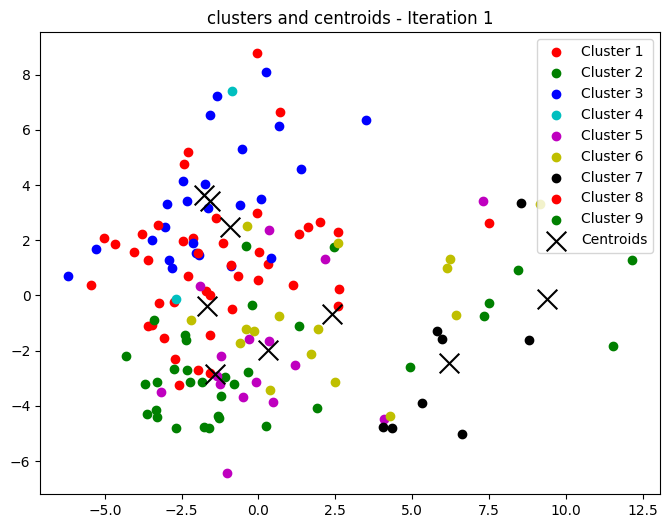

accuracy: 76.19%
F1 score: 0.75
confusion matrix:
[[30  5]
 [10 18]]


C:\Users\Hugo\AppData\Local\Temp\ipykernel_13428\1893245688.py:11: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  most_common_label, _ = mode(int_labels[mask], axis=None)


In [41]:
#The range of k is chosen according to the size of the datasets, for most, k is tried up to 30.
highest_k = int(sqrt(X.shape[0]/2))
if highest_k < 10:
    highest_k = 10
if highest_k > 30:
    highest_k = 30
    
k_values = [i for i in range(2,highest_k+1)]
print(f'range of k values tested: [2;{highest_k}]')

#Cross-validation to find the best k
best_k = cross_validation(X_train, Y_train, k_values)
print(f"the best value of k is {best_k}")

#Centroids and cluster_labels computation using the best value of k
centroids, cluster_labels = k_means(X_train, best_k)

#Clusters labels prediction
cluster_labels = np.array([np.argmin([euclidean_distance(point, centroid) for centroid in centroids]) for point in X_test])

accuracy, f1, cm = calculate_metrics(cluster_labels, Y_test)
print(f"accuracy: {accuracy * 100:.2f}%")
print(f"F1 score: {f1:.2f}")
print(f"confusion matrix:\n{cm}")

### Musk (Version 2)

In [42]:
X, X_names, y, y_name = load_dataset(id = dataset_ids["musk2"])
split_size = 0.7
X_train, Y_train, X_test, Y_test = preprocessing(X, y, split_size)
print(f'training set size: {X_train.shape}')
print(f'testing set size: {X_test.shape}')

data url:
 https://archive.ics.uci.edu/static/public/75/data.csv
training set size: (4618, 166)
testing set size: (1980, 166)


In [43]:
print_useful_data(X, X_names, y, y_name)

number of instances:  6598
number of features:  166
names of the features:
 ['f1' 'f2' 'f3' 'f4' 'f5' 'f6' 'f7' 'f8' 'f9' 'f10' 'f11' 'f12' 'f13'
 'f14' 'f15' 'f16' 'f17' 'f18' 'f19' 'f20' 'f21' 'f22' 'f23' 'f24' 'f25'
 'f26' 'f27' 'f28' 'f29' 'f30' 'f31' 'f32' 'f33' 'f34' 'f35' 'f36' 'f37'
 'f38' 'f39' 'f40' 'f41' 'f42' 'f43' 'f44' 'f45' 'f46' 'f47' 'f48' 'f49'
 'f50' 'f51' 'f52' 'f53' 'f54' 'f55' 'f56' 'f57' 'f58' 'f59' 'f60' 'f61'
 'f62' 'f63' 'f64' 'f65' 'f66' 'f67' 'f68' 'f69' 'f70' 'f71' 'f72' 'f73'
 'f74' 'f75' 'f76' 'f77' 'f78' 'f79' 'f80' 'f81' 'f82' 'f83' 'f84' 'f85'
 'f86' 'f87' 'f88' 'f89' 'f90' 'f91' 'f92' 'f93' 'f94' 'f95' 'f96' 'f97'
 'f98' 'f99' 'f100' 'f101' 'f102' 'f103' 'f104' 'f105' 'f106' 'f107'
 'f108' 'f109' 'f110' 'f111' 'f112' 'f113' 'f114' 'f115' 'f116' 'f117'
 'f118' 'f119' 'f120' 'f121' 'f122' 'f123' 'f124' 'f125' 'f126' 'f127'
 'f128' 'f129' 'f130' 'f131' 'f132' 'f133' 'f134' 'f135' 'f136' 'f137'
 'f138' 'f139' 'f140' 'f141' 'f142' 'f143' 'f144' 'f145' 'f14

range of k values tested: [2;30]


C:\Users\Hugo\AppData\Local\Temp\ipykernel_13428\1893245688.py:11: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  most_common_label, _ = mode(int_labels[mask], axis=None)


predicted accuracy for k=2: 84.63%
predicted accuracy for k=3: 84.63%
predicted accuracy for k=4: 84.63%
predicted accuracy for k=5: 84.63%
predicted accuracy for k=6: 84.63%
predicted accuracy for k=7: 84.88%
predicted accuracy for k=8: 84.67%
predicted accuracy for k=9: 84.63%
predicted accuracy for k=10: 85.36%
predicted accuracy for k=11: 84.65%
predicted accuracy for k=12: 85.06%
predicted accuracy for k=13: 84.71%
predicted accuracy for k=14: 84.63%
predicted accuracy for k=15: 85.82%
predicted accuracy for k=16: 85.77%
predicted accuracy for k=17: 86.75%
predicted accuracy for k=18: 85.32%
predicted accuracy for k=19: 85.25%
predicted accuracy for k=20: 86.51%
predicted accuracy for k=21: 86.79%
predicted accuracy for k=22: 86.57%
predicted accuracy for k=23: 87.31%
predicted accuracy for k=24: 86.47%
predicted accuracy for k=25: 85.49%
predicted accuracy for k=26: 86.47%
predicted accuracy for k=27: 86.34%
predicted accuracy for k=28: 85.97%
predicted accuracy for k=29: 87.53%


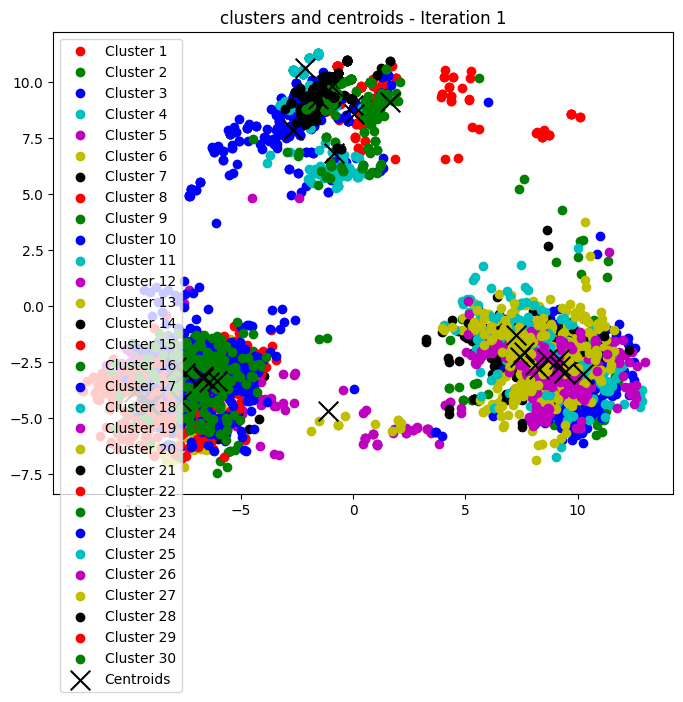

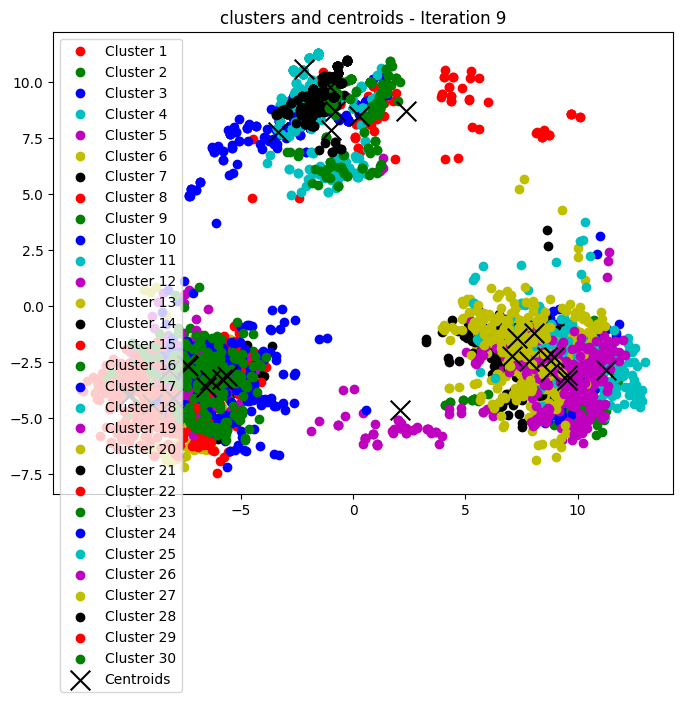

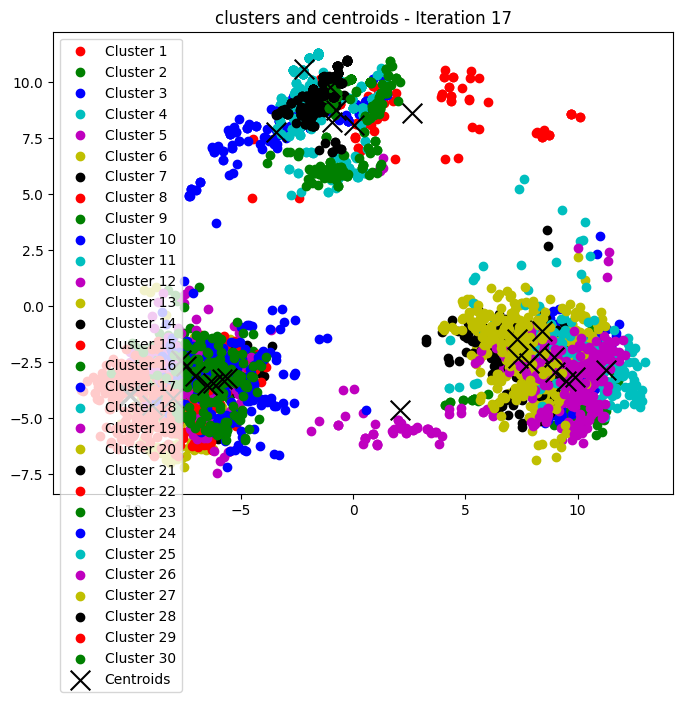

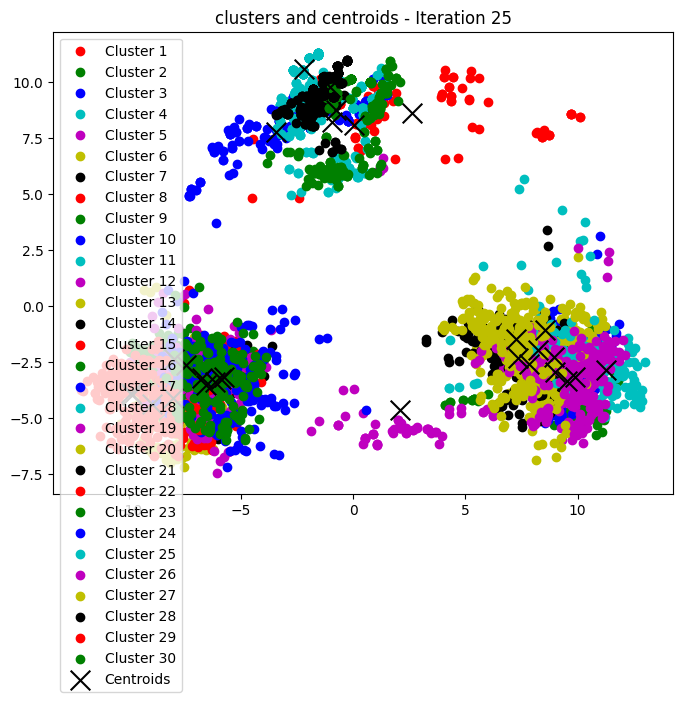

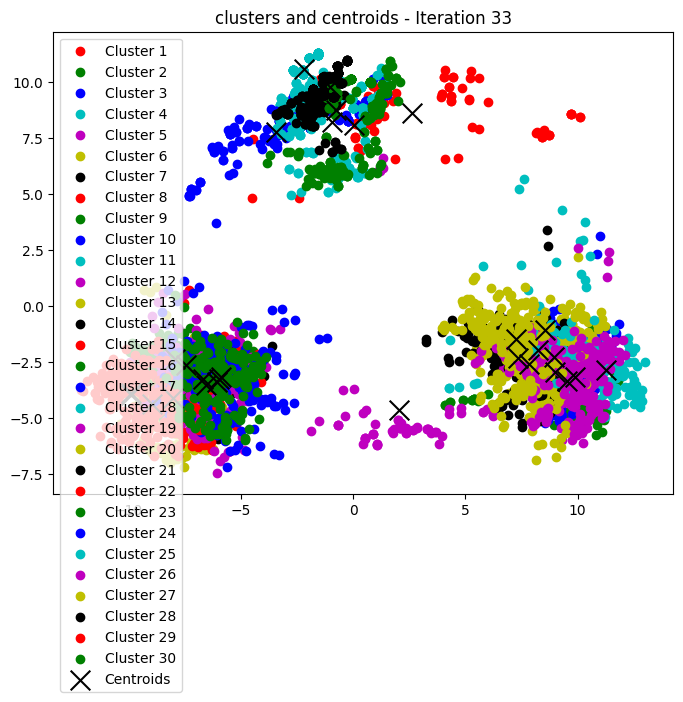

accuracy: 86.77%
F1 score: 0.71
confusion matrix:
[[1590   83]
 [ 179  128]]


C:\Users\Hugo\AppData\Local\Temp\ipykernel_13428\1893245688.py:11: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  most_common_label, _ = mode(int_labels[mask], axis=None)


In [44]:
#The range of k is chosen according to the size of the datasets, for most, k is tried up to 30.
highest_k = int(sqrt(X.shape[0]/2))
if highest_k < 10:
    highest_k = 10
if highest_k > 30:
    highest_k = 30
    
k_values = [i for i in range(2,highest_k+1)]
print(f'range of k values tested: [2;{highest_k}]')

#Cross-validation to find the best k
best_k = cross_validation(X_train, Y_train, k_values)
print(f"the best value of k is {best_k}")

#Centroids and cluster_labels computation using the best value of k
centroids, cluster_labels = k_means(X_train, best_k)

#Clusters labels prediction
cluster_labels = np.array([np.argmin([euclidean_distance(point, centroid) for centroid in centroids]) for point in X_test])

accuracy, f1, cm = calculate_metrics(cluster_labels, Y_test)
print(f"accuracy: {accuracy * 100:.2f}%")
print(f"F1 score: {f1:.2f}")
print(f"confusion matrix:\n{cm}")

### Breast Cancer Wisconsin (Diagnostic)

In [45]:
X, X_names, y, y_name = load_dataset(id = dataset_ids["bc-wisc-diag"])
split_size = 0.7
X_train, Y_train, X_test, Y_test = preprocessing(X, y, split_size)
print(f'training set size: {X_train.shape}')
print(f'testing set size: {X_test.shape}')

data url:
 https://archive.ics.uci.edu/static/public/17/data.csv
training set size: (398, 30)
testing set size: (171, 30)


In [46]:
print_useful_data(X, X_names, y, y_name)

number of instances:  569
number of features:  30
names of the features:
 ['radius1' 'texture1' 'perimeter1' 'area1' 'smoothness1' 'compactness1'
 'concavity1' 'concave_points1' 'symmetry1' 'fractal_dimension1' 'radius2'
 'texture2' 'perimeter2' 'area2' 'smoothness2' 'compactness2' 'concavity2'
 'concave_points2' 'symmetry2' 'fractal_dimension2' 'radius3' 'texture3'
 'perimeter3' 'area3' 'smoothness3' 'compactness3' 'concavity3'
 'concave_points3' 'symmetry3' 'fractal_dimension3']
name of the output label:  ['Diagnosis']
instance 0 feature vector:
 [1.799e+01 1.038e+01 1.228e+02 1.001e+03 1.184e-01 2.776e-01 3.001e-01
 1.471e-01 2.419e-01 7.871e-02 1.095e+00 9.053e-01 8.589e+00 1.534e+02
 6.399e-03 4.904e-02 5.373e-02 1.587e-02 3.003e-02 6.193e-03 2.538e+01
 1.733e+01 1.846e+02 2.019e+03 1.622e-01 6.656e-01 7.119e-01 2.654e-01
 4.601e-01 1.189e-01]
instance 0 output label:  ['M']


range of k values tested: [2;16]


C:\Users\Hugo\AppData\Local\Temp\ipykernel_13428\1893245688.py:11: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  most_common_label, _ = mode(int_labels[mask], axis=None)


predicted accuracy for k=2: 90.97%
predicted accuracy for k=3: 86.69%
predicted accuracy for k=4: 88.20%
predicted accuracy for k=5: 89.19%
predicted accuracy for k=6: 91.22%
predicted accuracy for k=7: 91.98%
predicted accuracy for k=8: 90.97%
predicted accuracy for k=9: 92.47%
predicted accuracy for k=10: 94.23%
predicted accuracy for k=11: 92.72%
predicted accuracy for k=12: 92.73%
predicted accuracy for k=13: 92.46%
predicted accuracy for k=14: 93.47%
predicted accuracy for k=15: 94.48%
predicted accuracy for k=16: 94.22%
the best value of k is 15


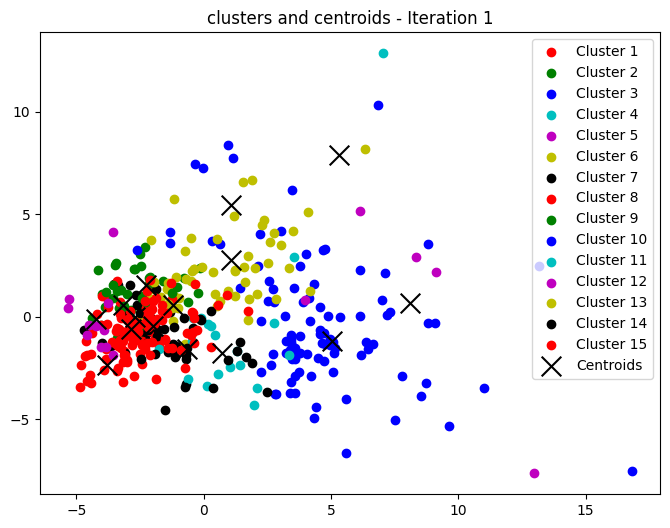

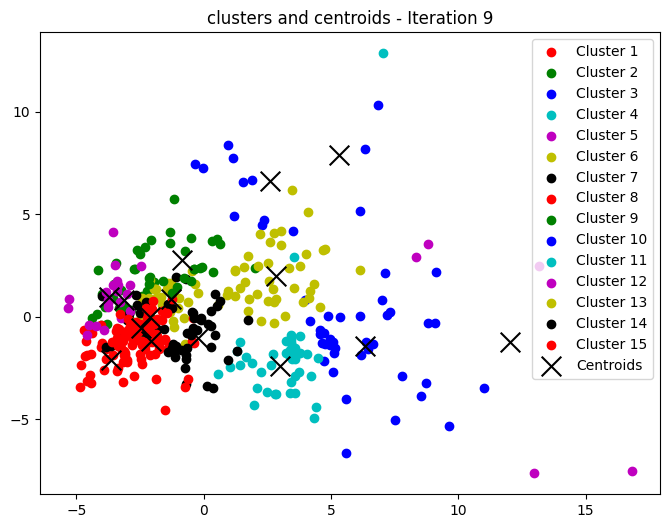

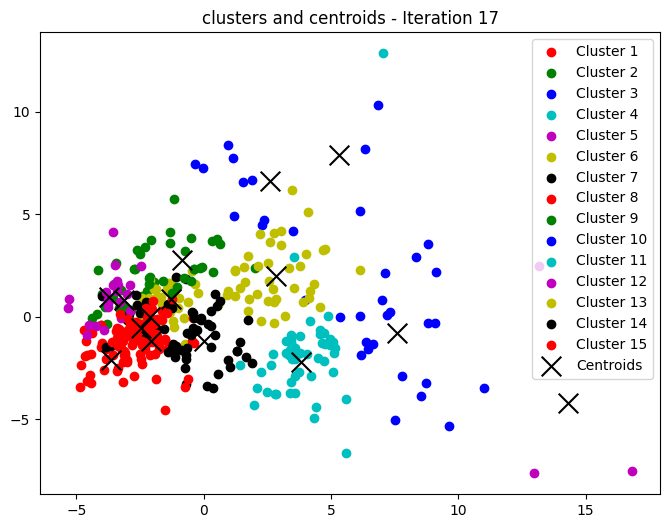

accuracy: 92.98%
F1 score: 0.92
confusion matrix:
[[102   6]
 [  6  57]]


C:\Users\Hugo\AppData\Local\Temp\ipykernel_13428\1893245688.py:11: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  most_common_label, _ = mode(int_labels[mask], axis=None)


In [47]:
#The range of k is chosen according to the size of the datasets, for most, k is tried up to 30.
highest_k = int(sqrt(X.shape[0]/2))
if highest_k < 10:
    highest_k = 10
if highest_k > 30:
    highest_k = 30
    
k_values = [i for i in range(2,highest_k+1)]
print(f'range of k values tested: [2;{highest_k}]')

#Cross-validation to find the best k
best_k = cross_validation(X_train, Y_train, k_values)
print(f"the best value of k is {best_k}")

#Centroids and cluster_labels computation using the best value of k
centroids, cluster_labels = k_means(X_train, best_k)

#Clusters labels prediction
cluster_labels = np.array([np.argmin([euclidean_distance(point, centroid) for centroid in centroids]) for point in X_test])

accuracy, f1, cm = calculate_metrics(cluster_labels, Y_test)
print(f"accuracy: {accuracy * 100:.2f}%")
print(f"F1 score: {f1:.2f}")
print(f"confusion matrix:\n{cm}")

### Balance-scale

In [48]:
X, X_names, y, y_name = load_dataset(id = dataset_ids["balance-scale"])
split_size = 0.7
X_train, Y_train, X_test, Y_test = preprocessing(X, y, split_size)
print(f'training set size: {X_train.shape}')
print(f'testing set size: {X_test.shape}')

data url:
 https://archive.ics.uci.edu/static/public/12/data.csv
training set size: (437, 4)
testing set size: (188, 4)


In [49]:
print_useful_data(X, X_names, y, y_name)

number of instances:  625
number of features:  4
names of the features:
 ['right-distance' 'right-weight' 'left-distance' 'left-weight']
name of the output label:  ['class']
instance 0 feature vector:
 [1 1 1 1]
instance 0 output label:  ['B']


range of k values tested: [2;17]


C:\Users\Hugo\AppData\Local\Temp\ipykernel_13428\1893245688.py:11: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  most_common_label, _ = mode(int_labels[mask], axis=None)


predicted accuracy for k=2: 66.33%
predicted accuracy for k=3: 75.07%
predicted accuracy for k=4: 70.01%
predicted accuracy for k=5: 69.56%
predicted accuracy for k=6: 73.22%
predicted accuracy for k=7: 82.14%
predicted accuracy for k=8: 79.17%
predicted accuracy for k=9: 79.39%
predicted accuracy for k=10: 80.98%
predicted accuracy for k=11: 81.68%
predicted accuracy for k=12: 78.70%
predicted accuracy for k=13: 81.69%
predicted accuracy for k=14: 80.75%
predicted accuracy for k=15: 81.23%
predicted accuracy for k=16: 81.68%
predicted accuracy for k=17: 82.59%
the best value of k is 17


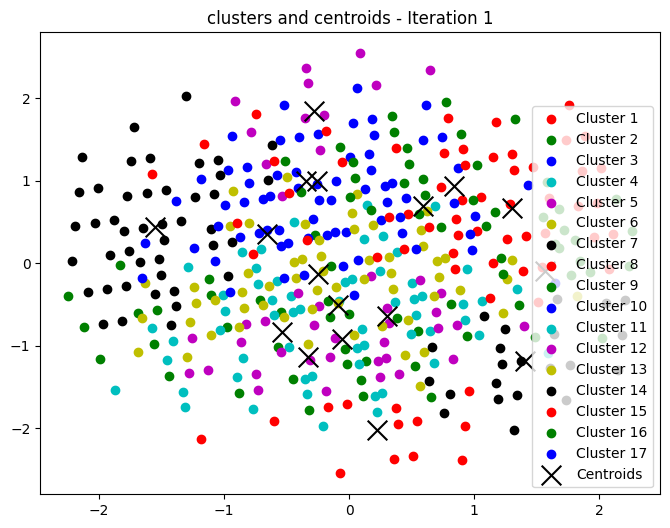

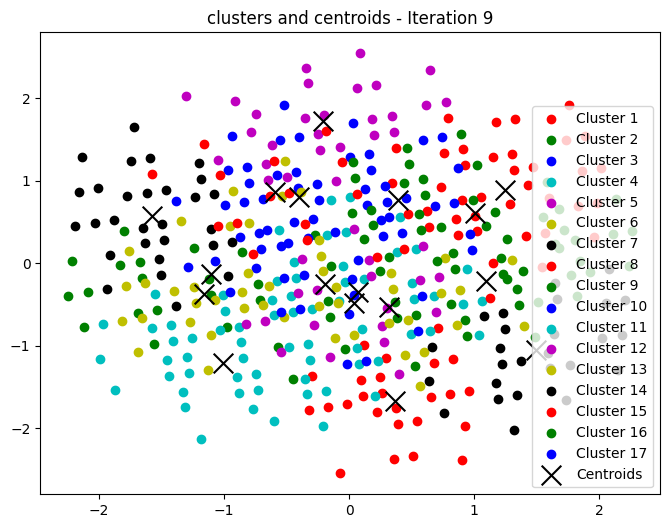

accuracy: 75.00%
F1 score: 0.53
confusion matrix:
[[ 0  8 10]
 [ 0 71  9]
 [ 0 20 70]]


C:\Users\Hugo\AppData\Local\Temp\ipykernel_13428\1893245688.py:11: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  most_common_label, _ = mode(int_labels[mask], axis=None)


In [50]:
#The range of k is chosen according to the size of the datasets, for most, k is tried up to 30.
highest_k = int(sqrt(X.shape[0]/2))
if highest_k < 10:
    highest_k = 10
if highest_k > 30:
    highest_k = 30
    
k_values = [i for i in range(2,highest_k+1)]
print(f'range of k values tested: [2;{highest_k}]')

#Cross-validation to find the best k
best_k = cross_validation(X_train, Y_train, k_values)
print(f"the best value of k is {best_k}")

#Centroids and cluster_labels computation using the best value of k
centroids, cluster_labels = k_means(X_train, best_k)

#Clusters labels prediction
cluster_labels = np.array([np.argmin([euclidean_distance(point, centroid) for centroid in centroids]) for point in X_test])

accuracy, f1, cm = calculate_metrics(cluster_labels, Y_test)
print(f"accuracy: {accuracy * 100:.2f}%")
print(f"F1 score: {f1:.2f}")
print(f"confusion matrix:\n{cm}")

### Contraception

In [51]:
X, X_names, y, y_name = load_dataset(id = dataset_ids["contraception"])
split_size = 0.7
X_train, Y_train, X_test, Y_test = preprocessing(X, y, split_size)
print(f'training set size: {X_train.shape}')
print(f'testing set size: {X_test.shape}')

data url:
 https://archive.ics.uci.edu/static/public/30/data.csv
training set size: (1031, 9)
testing set size: (442, 9)


In [52]:
print_useful_data(X, X_names, y, y_name)

number of instances:  1473
number of features:  9
names of the features:
 ['wife_age' 'wife_edu' 'husband_edu' 'num_children' 'wife_religion'
 'wife_working' 'husband_occupation' 'standard_of_living_index'
 'media_exposure']
name of the output label:  ['contraceptive_method']
instance 0 feature vector:
 [24  2  3  3  1  1  2  3  0]
instance 0 output label:  [1]


In [53]:
#Centroids and cluster_labels computation using the best value of k
centroids, cluster_labels = k_means(X_train, 75, visualization = False)

#Clusters labels prediction
cluster_labels = np.array([np.argmin([euclidean_distance(point, centroid) for centroid in centroids]) for point in X_test])

accuracy, f1, cm = calculate_metrics(cluster_labels, Y_test)
print(f"accuracy: {accuracy * 100:.2f}%")
print(f"F1 score: {f1:.2f}")
print(f"confusion matrix:\n{cm}")

accuracy: 59.73%
F1 score: 0.57
confusion matrix:
[[140  20  34]
 [ 38  43  20]
 [ 56  10  81]]


C:\Users\Hugo\AppData\Local\Temp\ipykernel_13428\1893245688.py:11: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  most_common_label, _ = mode(int_labels[mask], axis=None)


### Fertility

In [54]:
X, X_names, y, y_name = load_dataset(id = dataset_ids["fertility"])
split_size = 0.7
X_train, Y_train, X_test, Y_test = preprocessing(X, y, split_size)
print(f'training set size: {X_train.shape}')
print(f'testing set size: {X_test.shape}')

data url:
 https://archive.ics.uci.edu/static/public/244/data.csv
training set size: (70, 9)
testing set size: (30, 9)


In [55]:
print_useful_data(X, X_names, y, y_name)

number of instances:  100
number of features:  9
names of the features:
 ['season' 'age' 'child_diseases' 'accident' 'surgical_intervention'
 'high_fevers' 'alcohol' 'smoking' 'hrs_sitting']
name of the output label:  ['diagnosis']
instance 0 feature vector:
 [-0.33  0.69  0.    1.    1.    0.    0.8   0.    0.88]
instance 0 output label:  ['N']


range of k values tested: [2;10]
predicted accuracy for k=2: 87.14%
predicted accuracy for k=3: 87.14%
predicted accuracy for k=4: 87.14%


C:\Users\Hugo\AppData\Local\Temp\ipykernel_13428\1893245688.py:11: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  most_common_label, _ = mode(int_labels[mask], axis=None)


predicted accuracy for k=5: 87.14%
predicted accuracy for k=6: 87.14%
predicted accuracy for k=7: 90.00%
predicted accuracy for k=8: 87.14%
predicted accuracy for k=9: 91.43%
predicted accuracy for k=10: 88.57%
the best value of k is 9


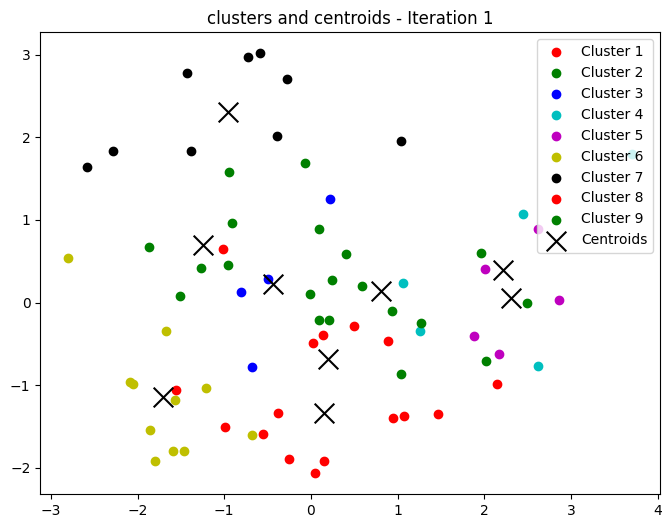

accuracy: 90.00%
F1 score: 0.47
confusion matrix:
[[27  0]
 [ 3  0]]


C:\Users\Hugo\AppData\Local\Temp\ipykernel_13428\1893245688.py:11: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  most_common_label, _ = mode(int_labels[mask], axis=None)


In [56]:
#The range of k is chosen according to the size of the datasets, for most, k is tried up to 30.
highest_k = int(sqrt(X.shape[0]/2))
if highest_k < 10:
    highest_k = 10
if highest_k > 30:
    highest_k = 30
    
k_values = [i for i in range(2,highest_k+1)]
print(f'range of k values tested: [2;{highest_k}]')

#Cross-validation to find the best k
best_k = cross_validation(X_train, Y_train, k_values)
print(f"the best value of k is {best_k}")

#Centroids and cluster_labels computation using the best value of k
centroids, cluster_labels = k_means(X_train, best_k)

#Clusters labels prediction
cluster_labels = np.array([np.argmin([euclidean_distance(point, centroid) for centroid in centroids]) for point in X_test])

accuracy, f1, cm = calculate_metrics(cluster_labels, Y_test)
print(f"accuracy: {accuracy * 100:.2f}%")
print(f"F1 score: {f1:.2f}")
print(f"confusion matrix:\n{cm}")

### Waveform (Version 1)

In [57]:
X, X_names, y, y_name = load_dataset(id = dataset_ids["waveform"])
split_size = 0.7
X_train, Y_train, X_test, Y_test = preprocessing(X, y, split_size)
print(f'training set size: {X_train.shape}')
print(f'testing set size: {X_test.shape}')

data url:
 https://archive.ics.uci.edu/static/public/107/data.csv
training set size: (3500, 21)
testing set size: (1500, 21)


In [58]:
print_useful_data(X, X_names, y, y_name)

number of instances:  5000
number of features:  21
names of the features:
 ['Attribute1' 'Attribute2' 'Attribute3' 'Attribute4' 'Attribute5'
 'Attribute6' 'Attribute7' 'Attribute8' 'Attribute9' 'Attribute10'
 'Attribute11' 'Attribute12' 'Attribute13' 'Attribute14' 'Attribute15'
 'Attribute16' 'Attribute17' 'Attribute18' 'Attribute19' 'Attribute20'
 'Attribute21']
name of the output label:  ['class']
instance 0 feature vector:
 [-1.23 -1.56 -1.75 -0.28  0.6   2.22  0.85  0.21 -0.2   0.89  1.08  4.2
  2.89  7.75  4.59  3.15  5.12  3.32  1.2   0.24 -0.56]
instance 0 output label:  [2]


range of k values tested: [2;30]


C:\Users\Hugo\AppData\Local\Temp\ipykernel_13428\1893245688.py:11: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  most_common_label, _ = mode(int_labels[mask], axis=None)


predicted accuracy for k=2: 63.57%
predicted accuracy for k=3: 53.57%
predicted accuracy for k=4: 64.63%
predicted accuracy for k=5: 73.20%
predicted accuracy for k=6: 73.71%
predicted accuracy for k=7: 75.91%
predicted accuracy for k=8: 74.46%
predicted accuracy for k=9: 76.06%
predicted accuracy for k=10: 75.83%
predicted accuracy for k=11: 77.71%
predicted accuracy for k=12: 75.83%
predicted accuracy for k=13: 78.14%
predicted accuracy for k=14: 77.17%
predicted accuracy for k=15: 77.09%
predicted accuracy for k=16: 77.54%
predicted accuracy for k=17: 76.89%
predicted accuracy for k=18: 77.74%
predicted accuracy for k=19: 78.31%
predicted accuracy for k=20: 77.66%
predicted accuracy for k=21: 78.63%
predicted accuracy for k=22: 76.91%
predicted accuracy for k=23: 78.14%
predicted accuracy for k=24: 78.51%
predicted accuracy for k=25: 78.54%
predicted accuracy for k=26: 78.46%
predicted accuracy for k=27: 78.26%
predicted accuracy for k=28: 78.91%
predicted accuracy for k=29: 79.06%


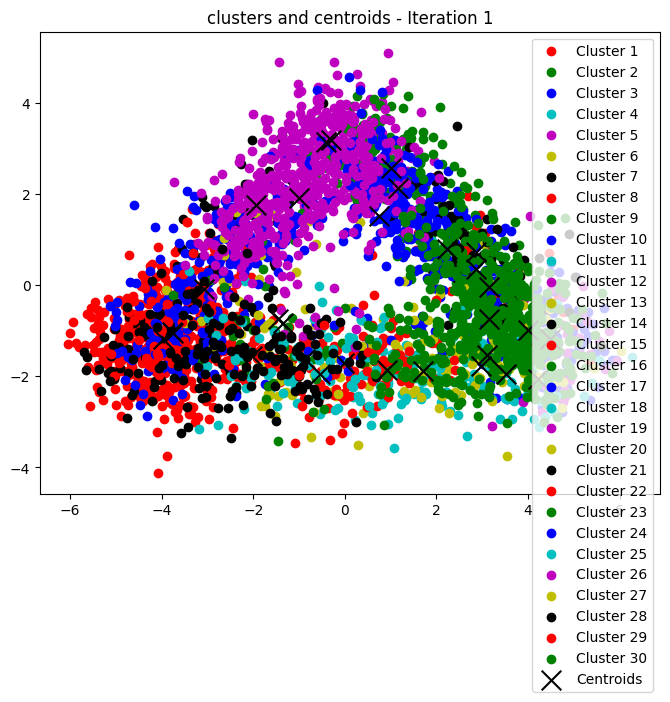

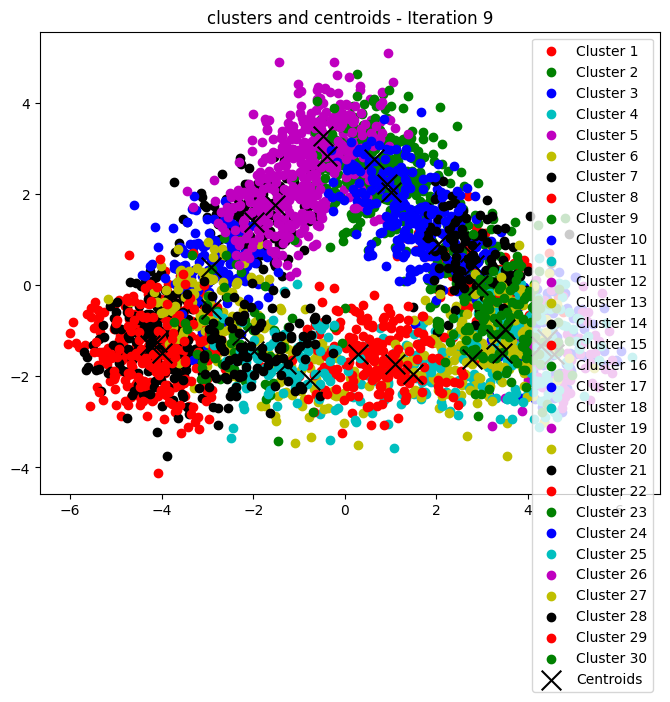

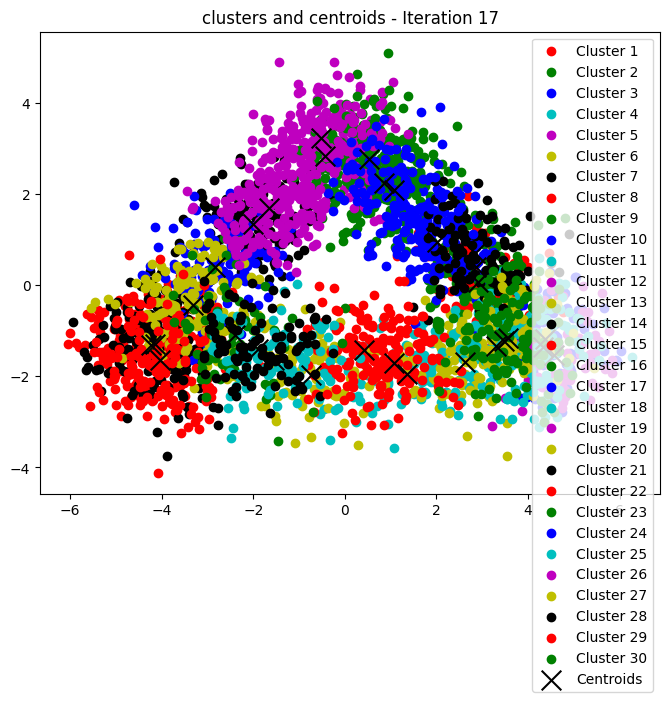

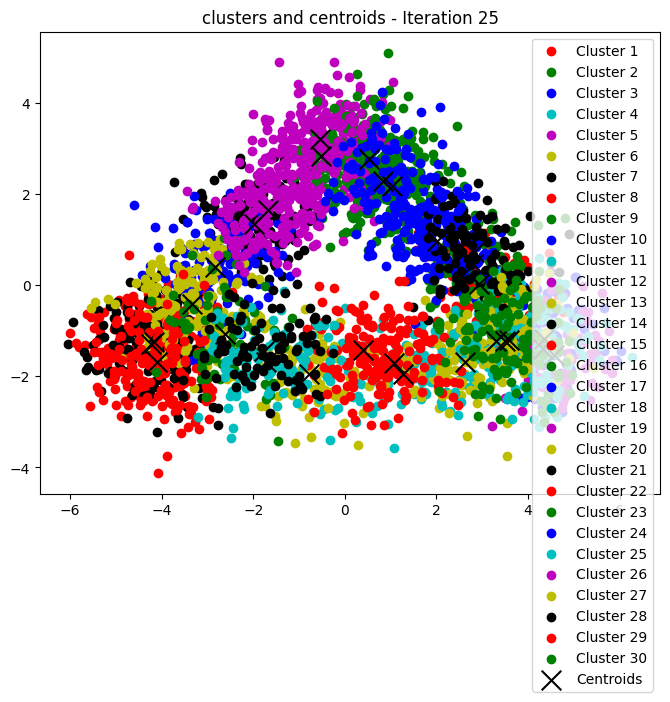

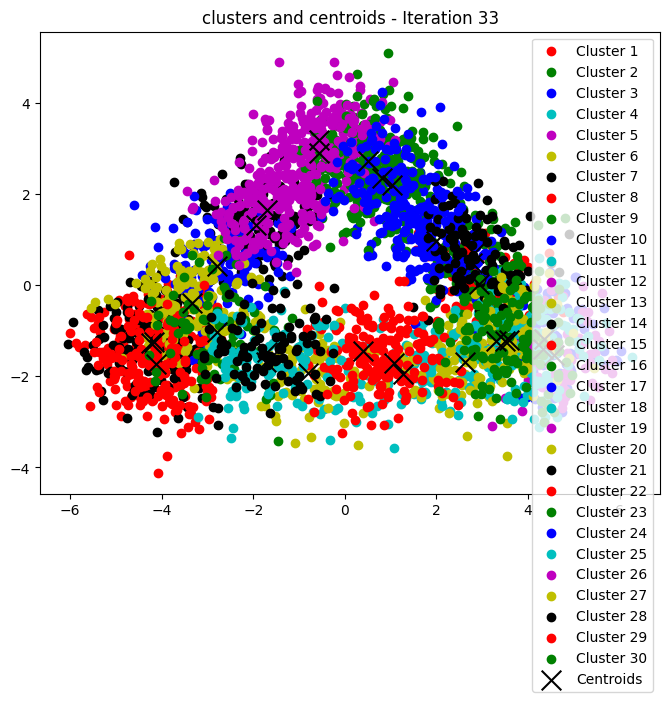

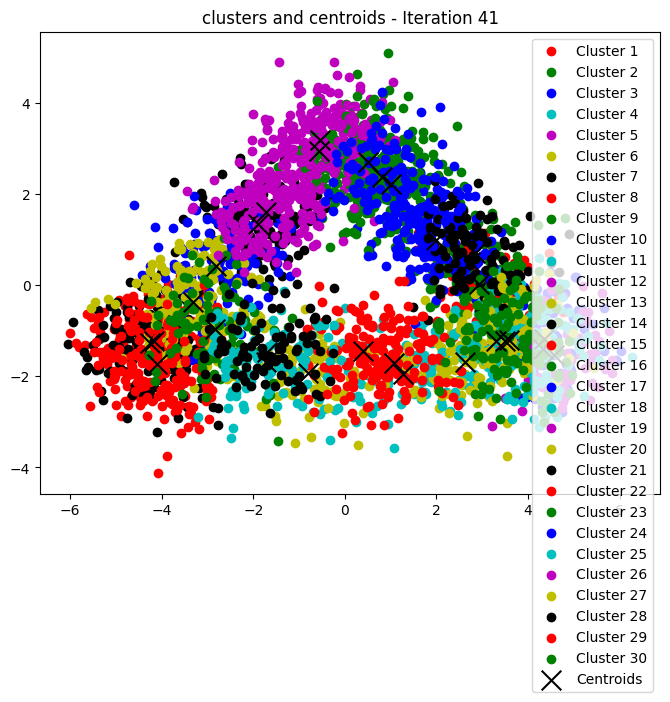

accuracy: 78.00%
F1 score: 0.78
confusion matrix:
[[321  78  87]
 [ 51 427  41]
 [ 29  44 422]]


C:\Users\Hugo\AppData\Local\Temp\ipykernel_13428\1893245688.py:11: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  most_common_label, _ = mode(int_labels[mask], axis=None)


In [59]:
#The range of k is chosen according to the size of the datasets, for most, k is tried up to 30.
highest_k = int(sqrt(X.shape[0]/2))
if highest_k < 10:
    highest_k = 10
if highest_k > 30:
    highest_k = 30
    
k_values = [i for i in range(2,highest_k+1)]
print(f'range of k values tested: [2;{highest_k}]')

#Cross-validation to find the best k
best_k = cross_validation(X_train, Y_train, k_values)
print(f"the best value of k is {best_k}")

#Centroids and cluster_labels computation using the best value of k
centroids, cluster_labels = k_means(X_train, best_k)

#Clusters labels prediction
cluster_labels = np.array([np.argmin([euclidean_distance(point, centroid) for centroid in centroids]) for point in X_test])

accuracy, f1, cm = calculate_metrics(cluster_labels, Y_test)
print(f"accuracy: {accuracy * 100:.2f}%")
print(f"F1 score: {f1:.2f}")
print(f"confusion matrix:\n{cm}")

### Image Segmentation

In [60]:
X, X_names, y, y_name = load_dataset(id = dataset_ids["image-segmentation"])
split_size = 0.7
X_train, Y_train, X_test, Y_test = preprocessing(X, y, split_size)
print(f'training set size: {X_train.shape}')
print(f'testing set size: {X_test.shape}')

data url:
 https://archive.ics.uci.edu/static/public/50/data.csv
training set size: (147, 19)
testing set size: (63, 19)


In [61]:
print_useful_data(X, X_names, y, y_name)

number of instances:  210
number of features:  19
names of the features:
 ['region-centroid-col' 'region-centroid-row' 'region-pixel-count'
 'short-line-density-5' 'short-line-density-2' 'vedge-mean' 'vedge-sd'
 'hedge-mean' 'hedge-sd' 'intensity-mean' 'rawred-mean' 'rawblue-mean'
 'rawgreen-mean' 'exred-mean' 'exblue-mean' 'exgreen-mean' 'value-mean'
 'saturation-mean' 'hue-mean']
name of the output label:  ['class']
instance 0 feature vector:
 [ 1.4000000e+02  1.2500000e+02  9.0000000e+00  0.0000000e+00
  0.0000000e+00  2.7777790e-01  6.2963010e-02  6.6666675e-01
  3.1111118e-01  6.1851850e+00  7.3333335e+00  7.6666665e+00
  3.5555556e+00  3.4444444e+00  4.4444447e+00 -7.8888890e+00
  7.7777777e+00  5.4563490e-01 -1.1218182e+00]
instance 0 output label:  ['BRICKFACE']


range of k values tested: [2;10]
predicted accuracy for k=2: 37.43%


C:\Users\Hugo\AppData\Local\Temp\ipykernel_13428\1893245688.py:11: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  most_common_label, _ = mode(int_labels[mask], axis=None)


predicted accuracy for k=3: 45.66%
predicted accuracy for k=4: 59.86%
predicted accuracy for k=5: 66.69%
predicted accuracy for k=6: 69.40%
predicted accuracy for k=7: 70.71%
predicted accuracy for k=8: 74.11%
predicted accuracy for k=9: 78.25%
predicted accuracy for k=10: 76.09%
the best value of k is 9


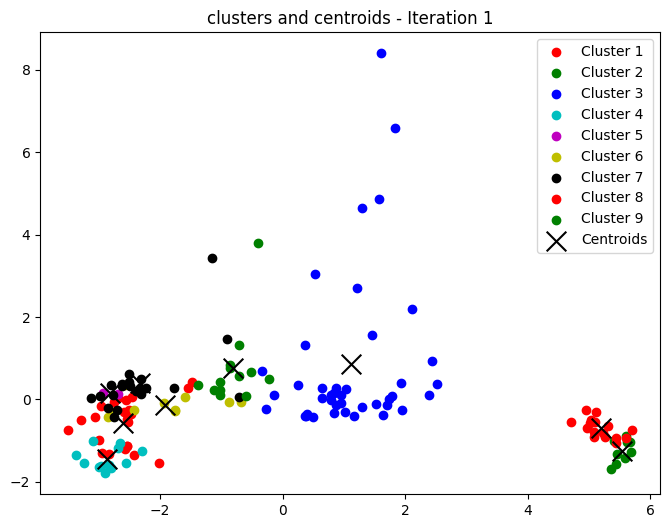

accuracy: 68.25%
F1 score: 0.66
confusion matrix:
[[ 8  0  0  0  0  0  1]
 [ 4  0  0  0  6  0  0]
 [ 4  0  5  0  1  0  1]
 [ 0  0  0 10  0  0  0]
 [ 0  0  0  0  9  0  0]
 [ 0  0  0  0  0  5  0]
 [ 2  0  1  0  0  0  6]]


C:\Users\Hugo\AppData\Local\Temp\ipykernel_13428\1893245688.py:11: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  most_common_label, _ = mode(int_labels[mask], axis=None)


In [62]:
#The range of k is chosen according to the size of the datasets, for most, k is tried up to 30.
highest_k = int(sqrt(X.shape[0]/2))
if highest_k < 10:
    highest_k = 10
if highest_k > 30:
    highest_k = 30
    
k_values = [i for i in range(2,highest_k+1)]
print(f'range of k values tested: [2;{highest_k}]')

#Cross-validation to find the best k
best_k = cross_validation(X_train, Y_train, k_values)
print(f"the best value of k is {best_k}")

#Centroids and cluster_labels computation using the best value of k
centroids, cluster_labels = k_means(X_train, best_k)

#Clusters labels prediction
cluster_labels = np.array([np.argmin([euclidean_distance(point, centroid) for centroid in centroids]) for point in X_test])

accuracy, f1, cm = calculate_metrics(cluster_labels, Y_test)
print(f"accuracy: {accuracy * 100:.2f}%")
print(f"F1 score: {f1:.2f}")
print(f"confusion matrix:\n{cm}")

### Blood Transfusion Service

In [63]:
X, X_names, y, y_name = load_dataset(id = dataset_ids["blood"])
split_size = 0.7
X_train, Y_train, X_test, Y_test = preprocessing(X, y, split_size)
print(f'training set size: {X_train.shape}')
print(f'testing set size: {X_test.shape}')

data url:
 https://archive.ics.uci.edu/static/public/176/data.csv
training set size: (523, 4)
testing set size: (225, 4)


In [64]:
print_useful_data(X, X_names, y, y_name)

number of instances:  748
number of features:  4
names of the features:
 ['Recency' 'Frequency' 'Monetary' 'Time']
name of the output label:  ['Donated_Blood']
instance 0 feature vector:
 [    2    50 12500    98]
instance 0 output label:  [1]


range of k values tested: [2;19]


C:\Users\Hugo\AppData\Local\Temp\ipykernel_13428\1893245688.py:11: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  most_common_label, _ = mode(int_labels[mask], axis=None)


predicted accuracy for k=2: 77.42%
predicted accuracy for k=3: 77.42%
predicted accuracy for k=4: 78.00%
predicted accuracy for k=5: 78.19%
predicted accuracy for k=6: 78.38%
predicted accuracy for k=7: 78.19%
predicted accuracy for k=8: 78.38%
predicted accuracy for k=9: 79.15%
predicted accuracy for k=10: 79.15%
predicted accuracy for k=11: 78.77%
predicted accuracy for k=12: 79.54%
predicted accuracy for k=13: 80.49%
predicted accuracy for k=14: 79.92%
predicted accuracy for k=15: 80.11%
predicted accuracy for k=16: 81.26%
predicted accuracy for k=17: 81.25%
predicted accuracy for k=18: 81.64%
predicted accuracy for k=19: 81.07%
the best value of k is 18


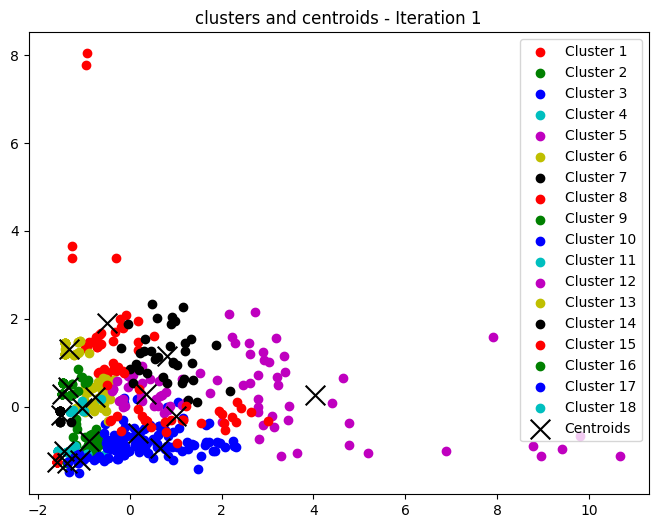

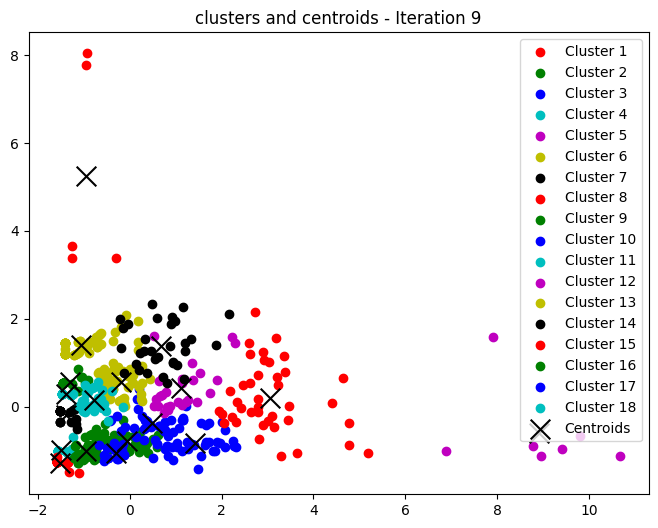

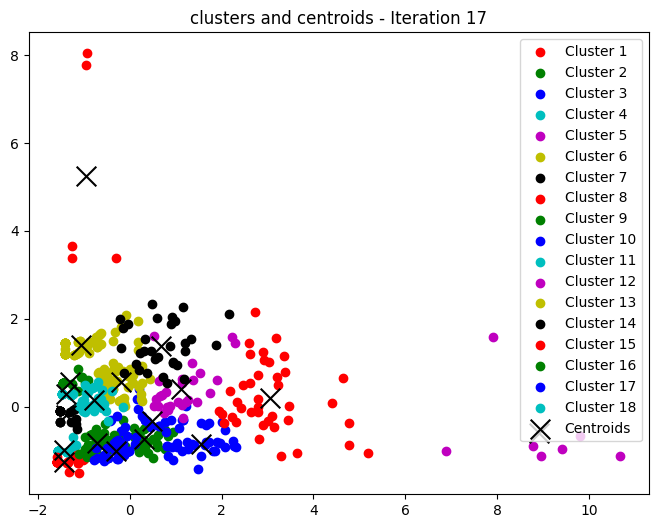

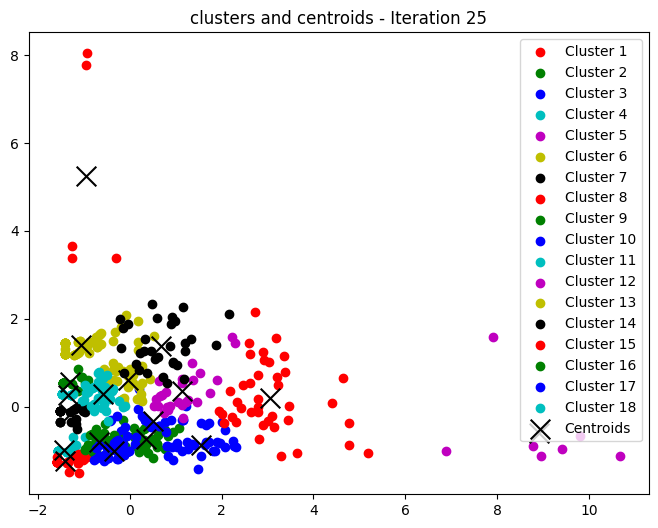

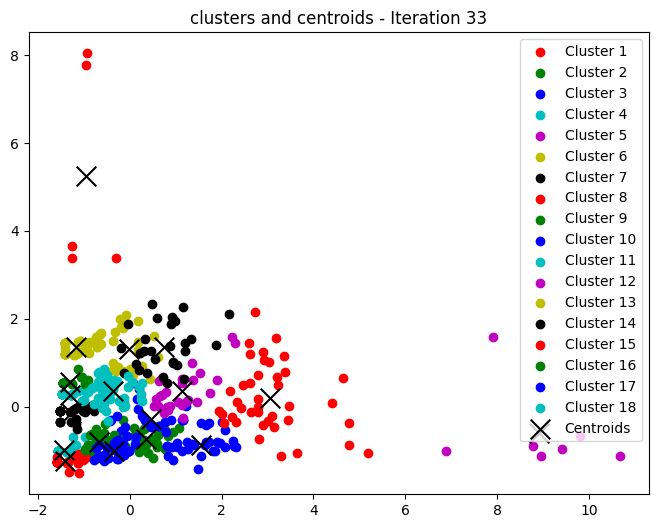

accuracy: 76.89%
F1 score: 0.62
confusion matrix:
[[157   8]
 [ 44  16]]


C:\Users\Hugo\AppData\Local\Temp\ipykernel_13428\1893245688.py:11: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  most_common_label, _ = mode(int_labels[mask], axis=None)


In [65]:
#The range of k is chosen according to the size of the datasets, for most, k is tried up to 30.
highest_k = int(sqrt(X.shape[0]/2))
if highest_k < 10:
    highest_k = 10
if highest_k > 30:
    highest_k = 30
    
k_values = [i for i in range(2,highest_k+1)]
print(f'range of k values tested: [2;{highest_k}]')

#Cross-validation to find the best k
best_k = cross_validation(X_train, Y_train, k_values)
print(f"the best value of k is {best_k}")

#Centroids and cluster_labels computation using the best value of k
centroids, cluster_labels = k_means(X_train, best_k)

#Clusters labels prediction
cluster_labels = np.array([np.argmin([euclidean_distance(point, centroid) for centroid in centroids]) for point in X_test])

accuracy, f1, cm = calculate_metrics(cluster_labels, Y_test)
print(f"accuracy: {accuracy * 100:.2f}%")
print(f"F1 score: {f1:.2f}")
print(f"confusion matrix:\n{cm}")

### SPECT Heart

In [66]:
X, X_names, y, y_name = load_dataset(id = dataset_ids["spect"])
split_size = 0.7
X_train, Y_train, X_test, Y_test = preprocessing(X, y, split_size)
print(f'training set size: {X_train.shape}')
print(f'testing set size: {X_test.shape}')

data url:
 https://archive.ics.uci.edu/static/public/95/data.csv
training set size: (186, 22)
testing set size: (81, 22)


In [67]:
print_useful_data(X, X_names, y, y_name)

number of instances:  267
number of features:  22
names of the features:
 ['F1' 'F2' 'F3' 'F4' 'F5' 'F6' 'F7' 'F8' 'F9' 'F10' 'F11' 'F12' 'F13'
 'F14' 'F15' 'F16' 'F17' 'F18' 'F19' 'F20' 'F21' 'F22']
name of the output label:  ['OVERALL_DIAGNOSIS']
instance 0 feature vector:
 [0 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0]
instance 0 output label:  [1]


range of k values tested: [2;11]


C:\Users\Hugo\AppData\Local\Temp\ipykernel_13428\1893245688.py:11: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  most_common_label, _ = mode(int_labels[mask], axis=None)


predicted accuracy for k=2: 78.48%
predicted accuracy for k=3: 79.02%
predicted accuracy for k=4: 79.02%
predicted accuracy for k=5: 81.15%
predicted accuracy for k=6: 80.09%
predicted accuracy for k=7: 80.64%
predicted accuracy for k=8: 79.54%
predicted accuracy for k=9: 84.95%
predicted accuracy for k=10: 85.48%
predicted accuracy for k=11: 84.37%
the best value of k is 10


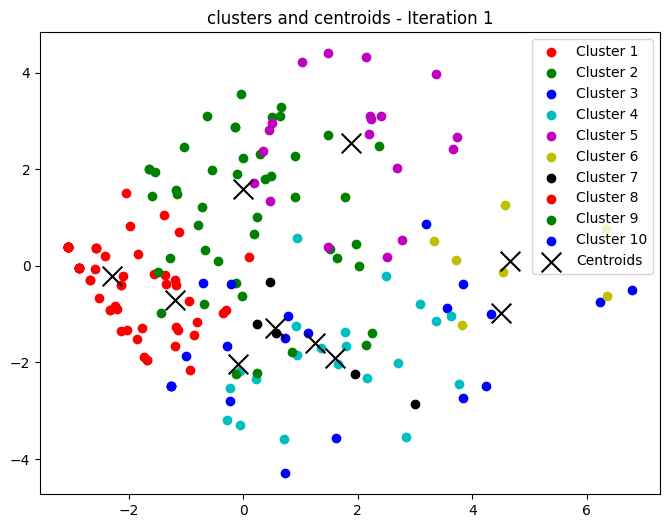

accuracy: 81.48%
F1 score: 0.45
confusion matrix:
[[ 0 15]
 [ 0 66]]


C:\Users\Hugo\AppData\Local\Temp\ipykernel_13428\1893245688.py:11: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  most_common_label, _ = mode(int_labels[mask], axis=None)


In [68]:
#The range of k is chosen according to the size of the datasets, for most, k is tried up to 30.
highest_k = int(sqrt(X.shape[0]/2))
if highest_k < 10:
    highest_k = 10
if highest_k > 30:
    highest_k = 30
    
k_values = [i for i in range(2,highest_k+1)]
print(f'range of k values tested: [2;{highest_k}]')

#Cross-validation to find the best k
best_k = cross_validation(X_train, Y_train, k_values)
print(f"the best value of k is {best_k}")

#Centroids and cluster_labels computation using the best value of k
centroids, cluster_labels = k_means(X_train, best_k)

#Clusters labels prediction
cluster_labels = np.array([np.argmin([euclidean_distance(point, centroid) for centroid in centroids]) for point in X_test])

accuracy, f1, cm = calculate_metrics(cluster_labels, Y_test)
print(f"accuracy: {accuracy * 100:.2f}%")
print(f"F1 score: {f1:.2f}")
print(f"confusion matrix:\n{cm}")

### Statlog (Landsat Satellite)

In [69]:
X, X_names, y, y_name = load_dataset(id = dataset_ids["landsat"])
split_size = 0.7
X_train, Y_train, X_test, Y_test = preprocessing(X, y, split_size)
print(f'training set size: {X_train.shape}')
print(f'testing set size: {X_test.shape}')

data url:
 https://archive.ics.uci.edu/static/public/146/data.csv
training set size: (4504, 36)
testing set size: (1931, 36)


In [70]:
print_useful_data(X, X_names, y, y_name)

number of instances:  6435
number of features:  36
names of the features:
 ['Attribute1' 'Attribute2' 'Attribute3' 'Attribute4' 'Attribute5'
 'Attribute6' 'Attribute7' 'Attribute8' 'Attribute9' 'Attribute10'
 'Attribute11' 'Attribute12' 'Attribute13' 'Attribute14' 'Attribute15'
 'Attribute16' 'Attribute17' 'Attribute18' 'Attribute19' 'Attribute20'
 'Attribute21' 'Attribute22' 'Attribute23' 'Attribute24' 'Attribute25'
 'Attribute26' 'Attribute27' 'Attribute28' 'Attribute29' 'Attribute30'
 'Attribute31' 'Attribute32' 'Attribute33' 'Attribute34' 'Attribute35'
 'Attribute36']
name of the output label:  ['class']
instance 0 feature vector:
 [ 92 115 120  94  84 102 106  79  84 102 102  83 101 126 133 103  92 112
 118  85  84 103 104  81 102 126 134 104  88 121 128 100  84 107 113  87]
instance 0 output label:  [3]


range of k values tested: [2;30]


C:\Users\Hugo\AppData\Local\Temp\ipykernel_13428\1893245688.py:11: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  most_common_label, _ = mode(int_labels[mask], axis=None)


predicted accuracy for k=2: 39.17%
predicted accuracy for k=3: 52.89%
predicted accuracy for k=4: 60.19%
predicted accuracy for k=5: 67.32%
predicted accuracy for k=6: 72.82%
predicted accuracy for k=7: 76.15%
predicted accuracy for k=8: 78.02%
predicted accuracy for k=9: 78.26%
predicted accuracy for k=10: 79.88%
predicted accuracy for k=11: 80.97%
predicted accuracy for k=12: 80.64%
predicted accuracy for k=13: 81.44%
predicted accuracy for k=14: 81.44%
predicted accuracy for k=15: 82.06%
predicted accuracy for k=16: 82.44%
predicted accuracy for k=17: 82.59%
predicted accuracy for k=18: 82.53%
predicted accuracy for k=19: 83.57%
predicted accuracy for k=20: 83.28%
predicted accuracy for k=21: 83.37%
predicted accuracy for k=22: 82.97%
predicted accuracy for k=23: 83.59%
predicted accuracy for k=24: 83.55%
predicted accuracy for k=25: 83.88%
predicted accuracy for k=26: 84.57%
predicted accuracy for k=27: 84.12%
predicted accuracy for k=28: 84.35%
predicted accuracy for k=29: 84.32%


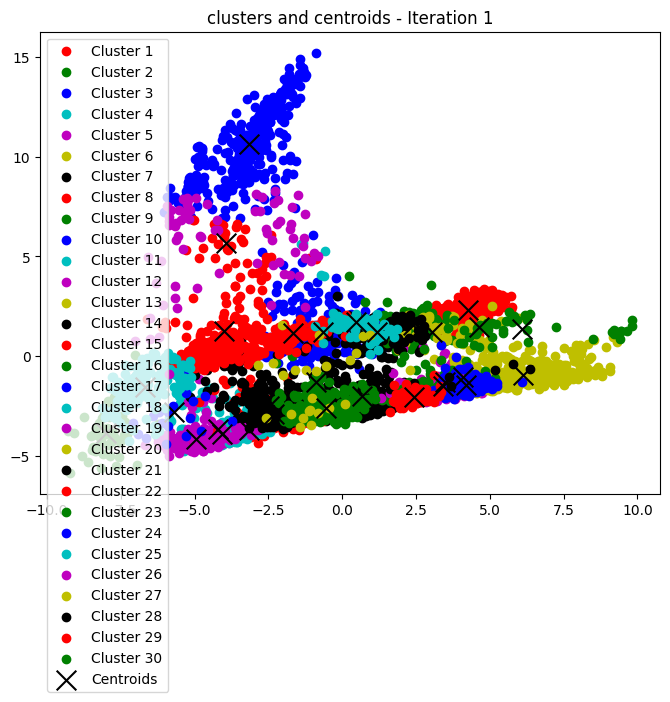

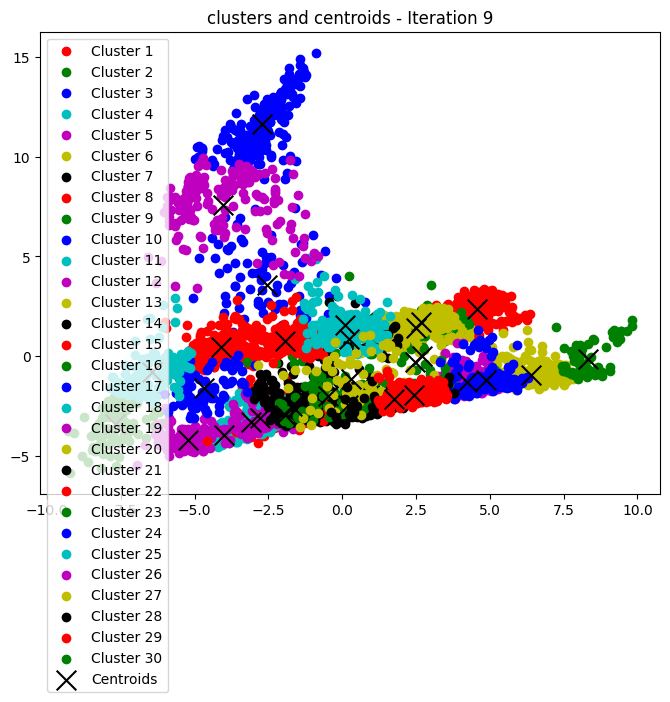

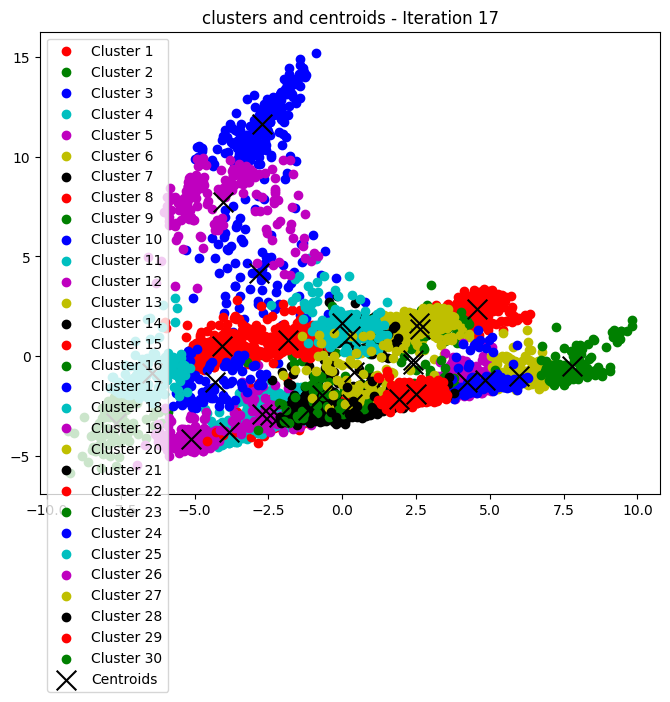

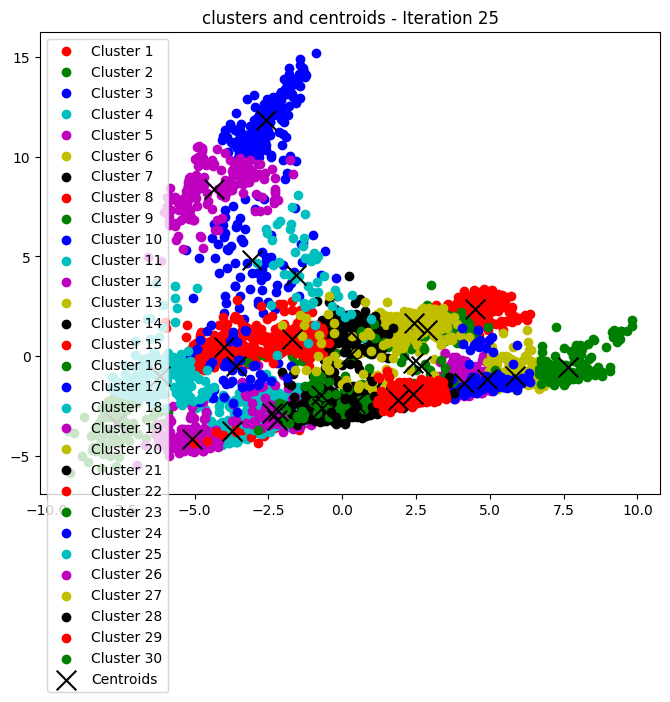

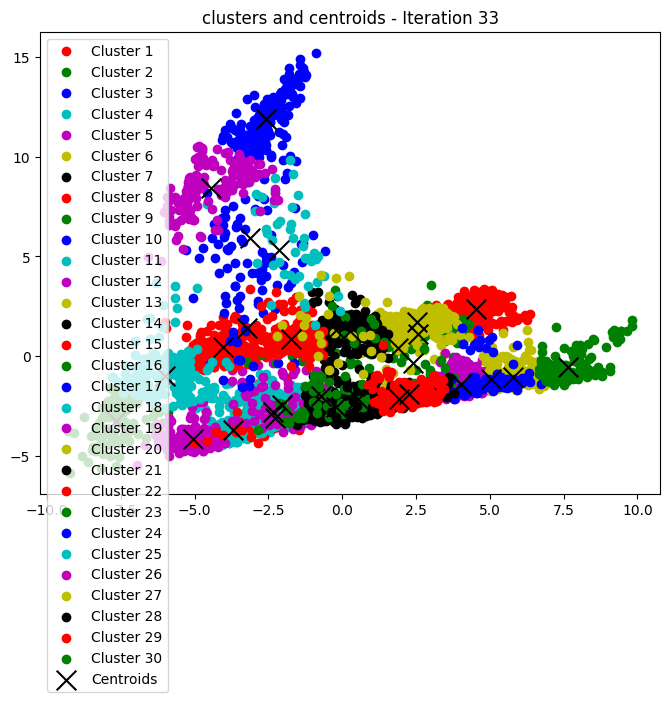

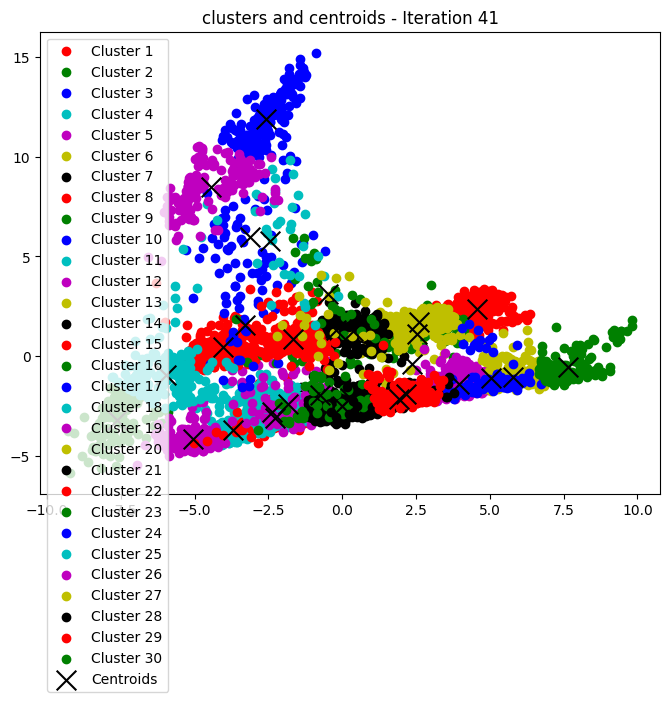

accuracy: 83.38%
F1 score: 0.81
confusion matrix:
[[433   5  12   0   0   0]
 [  3 179   0   0   3   1]
 [  2   2 367  37   0   8]
 [  4   0  26 128   0  43]
 [ 41   4   2   3 112  57]
 [  0   2   3  58   5 391]]


C:\Users\Hugo\AppData\Local\Temp\ipykernel_13428\1893245688.py:11: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  most_common_label, _ = mode(int_labels[mask], axis=None)


In [71]:
#The range of k is chosen according to the size of the datasets, for most, k is tried up to 30.
highest_k = int(sqrt(X.shape[0]/2))
if highest_k < 10:
    highest_k = 10
if highest_k > 30:
    highest_k = 30
    
k_values = [i for i in range(2,highest_k+1)]
print(f'range of k values tested: [2;{highest_k}]')

#Cross-validation to find the best k
best_k = cross_validation(X_train, Y_train, k_values)
print(f"the best value of k is {best_k}")

#Centroids and cluster_labels computation using the best value of k
centroids, cluster_labels = k_means(X_train, best_k)

#Clusters labels prediction
cluster_labels = np.array([np.argmin([euclidean_distance(point, centroid) for centroid in centroids]) for point in X_test])

accuracy, f1, cm = calculate_metrics(cluster_labels, Y_test)
print(f"accuracy: {accuracy * 100:.2f}%")
print(f"F1 score: {f1:.2f}")
print(f"confusion matrix:\n{cm}")

### Yeast

In [72]:
X, X_names, y, y_name = load_dataset(id = dataset_ids["yeast"])
split_size = 0.7
X_train, Y_train, X_test, Y_test = preprocessing(X, y, split_size)
print(f'training set size: {X_train.shape}')
print(f'testing set size: {X_test.shape}')

data url:
 https://archive.ics.uci.edu/static/public/110/data.csv
training set size: (1038, 8)
testing set size: (446, 8)


In [73]:
print_useful_data(X, X_names, y, y_name)

number of instances:  1484
number of features:  8
names of the features:
 ['mcg' 'gvh' 'alm' 'mit' 'erl' 'pox' 'vac' 'nuc']
name of the output label:  ['localization_site']
instance 0 feature vector:
 [0.58 0.61 0.47 0.13 0.5  0.   0.48 0.22]
instance 0 output label:  ['MIT']


range of k values tested: [2;27]


C:\Users\Hugo\AppData\Local\Temp\ipykernel_13428\1893245688.py:11: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  most_common_label, _ = mode(int_labels[mask], axis=None)


predicted accuracy for k=2: 34.78%
predicted accuracy for k=3: 36.61%
predicted accuracy for k=4: 40.27%
predicted accuracy for k=5: 46.82%
predicted accuracy for k=6: 48.45%
predicted accuracy for k=7: 52.12%
predicted accuracy for k=8: 53.08%
predicted accuracy for k=9: 54.62%
predicted accuracy for k=10: 55.78%
predicted accuracy for k=11: 55.49%
predicted accuracy for k=12: 55.97%
predicted accuracy for k=13: 55.78%
predicted accuracy for k=14: 56.45%
predicted accuracy for k=15: 56.26%
predicted accuracy for k=16: 57.32%
predicted accuracy for k=17: 57.03%
predicted accuracy for k=18: 57.80%
predicted accuracy for k=19: 58.00%
predicted accuracy for k=20: 56.74%
predicted accuracy for k=21: 58.96%
predicted accuracy for k=22: 59.06%
predicted accuracy for k=23: 59.06%
predicted accuracy for k=24: 59.15%
predicted accuracy for k=25: 59.73%
predicted accuracy for k=26: 59.06%
predicted accuracy for k=27: 59.15%
the best value of k is 25


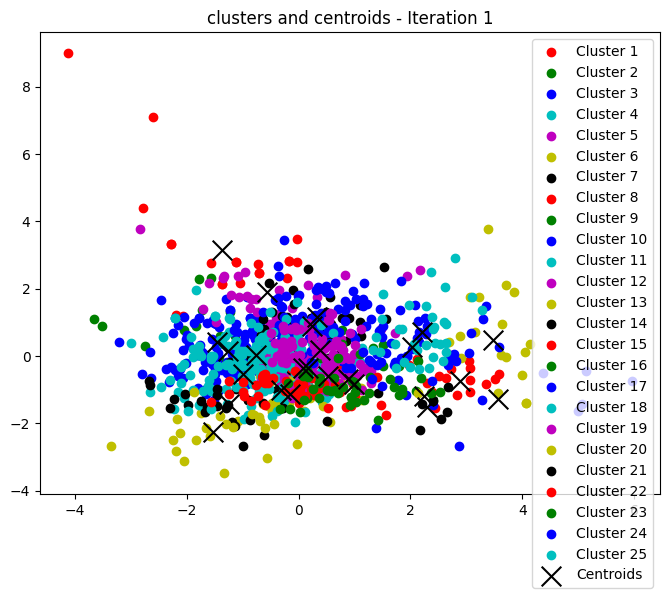

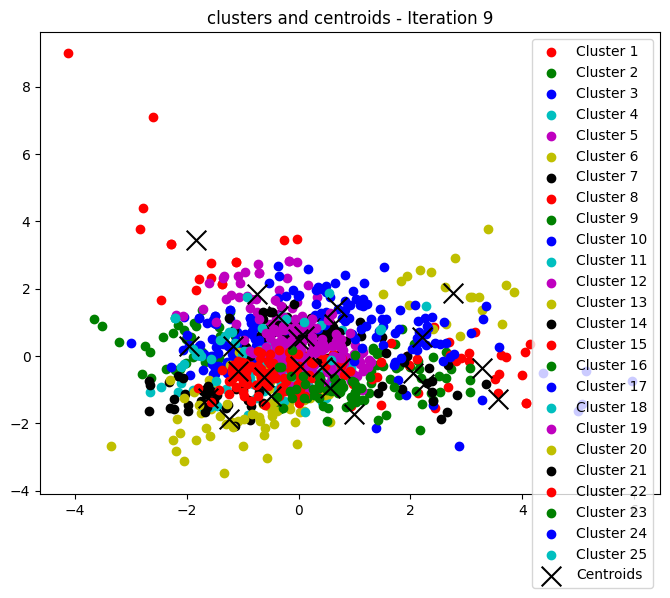

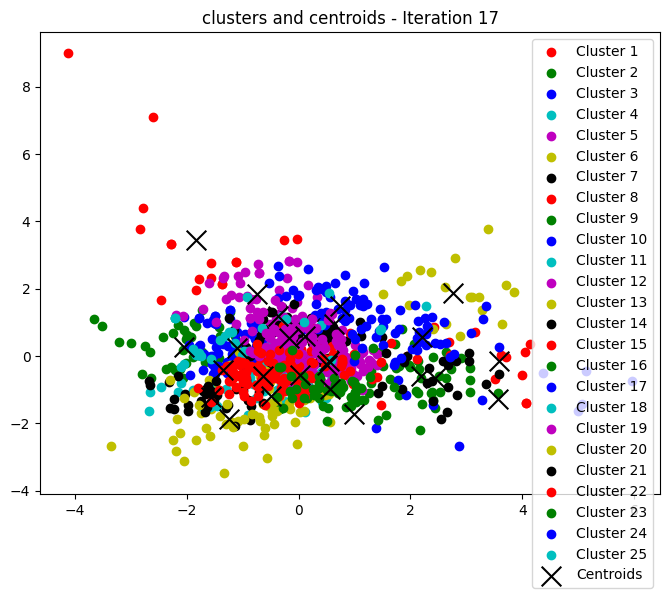

accuracy: 56.28%
F1 score: 0.53
confusion matrix:
[[104   2   0   1   1   7  30   0   0]
 [  2   7   1   0   0   0   0   0   0]
 [  0   5   9   1   0   0   0   0   0]
 [  2   1   2   5   0   0   1   0   0]
 [  4   0   2   1  35   1   8   0   0]
 [ 17   4   1   0   3  43   6   0   0]
 [ 64   2   1   0   4  10  45   0   0]
 [  0   1   0   0   0   0   0   3   0]
 [  3   1   2   0   2   1   1   0   0]]


C:\Users\Hugo\AppData\Local\Temp\ipykernel_13428\1893245688.py:11: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  most_common_label, _ = mode(int_labels[mask], axis=None)


In [74]:
#The range of k is chosen according to the size of the datasets, for most, k is tried up to 30.
highest_k = int(sqrt(X.shape[0]/2))
if highest_k < 10:
    highest_k = 10
if highest_k > 30:
    highest_k = 30
    
k_values = [i for i in range(2,highest_k+1)]
print(f'range of k values tested: [2;{highest_k}]')

#Cross-validation to find the best k
best_k = cross_validation(X_train, Y_train, k_values)
print(f"the best value of k is {best_k}")

#Centroids and cluster_labels computation using the best value of k
centroids, cluster_labels = k_means(X_train, best_k)

#Clusters labels prediction
cluster_labels = np.array([np.argmin([euclidean_distance(point, centroid) for centroid in centroids]) for point in X_test])

accuracy, f1, cm = calculate_metrics(cluster_labels, Y_test)
print(f"accuracy: {accuracy * 100:.2f}%")
print(f"F1 score: {f1:.2f}")
print(f"confusion matrix:\n{cm}")

### Monk

In [75]:
X, X_names, y, y_name = load_dataset(id = dataset_ids["monk"])
split_size = 0.7
X_train, Y_train, X_test, Y_test = preprocessing(X, y, split_size)
print(f'training set size: {X_train.shape}')
print(f'testing set size: {X_test.shape}')

data url:
 https://archive.ics.uci.edu/static/public/70/data.csv
training set size: (302, 6)
testing set size: (130, 6)


In [76]:
print_useful_data(X, X_names, y, y_name)

number of instances:  432
number of features:  6
names of the features:
 ['a1' 'a2' 'a3' 'a4' 'a5' 'a6']
name of the output label:  ['class']
instance 0 feature vector:
 [1 1 1 1 1 1]
instance 0 output label:  [1]


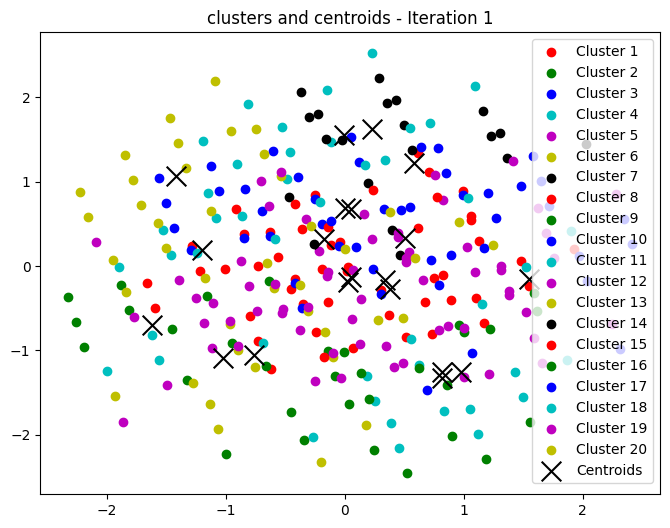

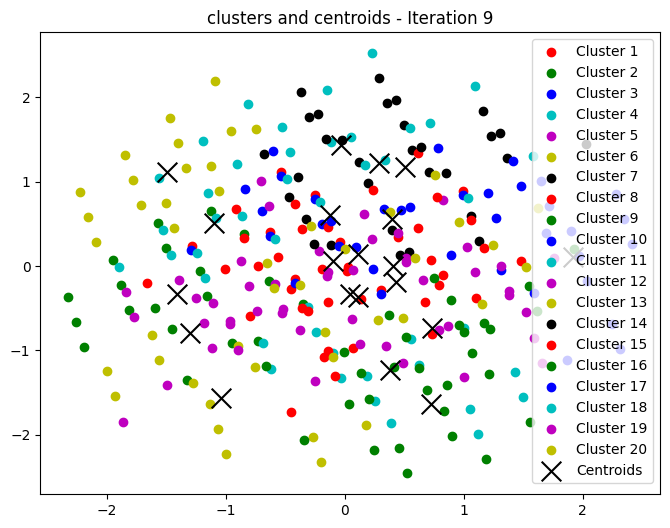

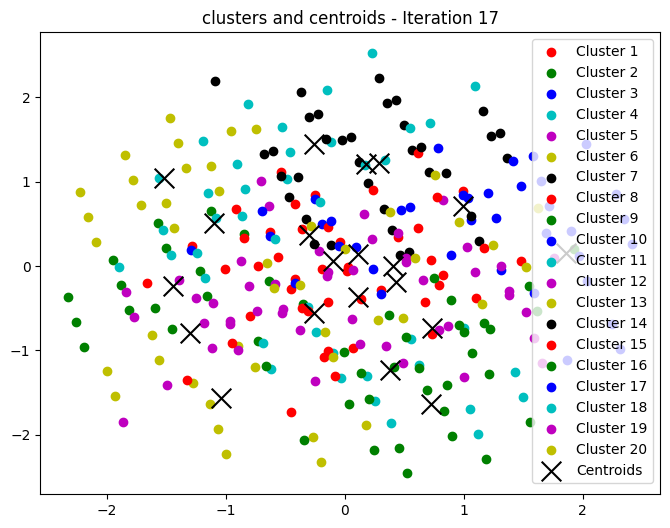

accuracy: 69.23%
F1 score: 0.69
confusion matrix:
[[40 21]
 [19 50]]


C:\Users\Hugo\AppData\Local\Temp\ipykernel_13428\1893245688.py:11: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  most_common_label, _ = mode(int_labels[mask], axis=None)


In [77]:
#Centroids and cluster_labels computation using the best value of k
centroids, cluster_labels = k_means(X_train, 20)

#Clusters labels prediction
cluster_labels = np.array([np.argmin([euclidean_distance(point, centroid) for centroid in centroids]) for point in X_test])

accuracy, f1, cm = calculate_metrics(cluster_labels, Y_test)
print(f"accuracy: {accuracy * 100:.2f}%")
print(f"F1 score: {f1:.2f}")
print(f"confusion matrix:\n{cm}")

### Ecoli

In [78]:
X, X_names, y, y_name = load_dataset(id = dataset_ids["ecoli"])
split_size = 0.7
X_train, Y_train, X_test, Y_test = preprocessing(X, y, split_size)
print(f'training set size: {X_train.shape}')
print(f'testing set size: {X_test.shape}')

data url:
 https://archive.ics.uci.edu/static/public/39/data.csv
training set size: (235, 7)
testing set size: (101, 7)


In [79]:
print_useful_data(X, X_names, y, y_name)

number of instances:  336
number of features:  7
names of the features:
 ['mcg' 'gvh' 'lip' 'chg' 'aac' 'alm1' 'alm2']
name of the output label:  ['class']
instance 0 feature vector:
 [0.49 0.29 0.48 0.5  0.56 0.24 0.35]
instance 0 output label:  ['cp']


range of k values tested: [2;12]


C:\Users\Hugo\AppData\Local\Temp\ipykernel_13428\1893245688.py:11: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  most_common_label, _ = mode(int_labels[mask], axis=None)


predicted accuracy for k=2: 62.98%
predicted accuracy for k=3: 77.45%
predicted accuracy for k=4: 78.72%
predicted accuracy for k=5: 77.87%
predicted accuracy for k=6: 80.85%
predicted accuracy for k=7: 82.13%
predicted accuracy for k=8: 80.43%
predicted accuracy for k=9: 82.13%
predicted accuracy for k=10: 82.13%
predicted accuracy for k=11: 82.98%
predicted accuracy for k=12: 84.26%
the best value of k is 12


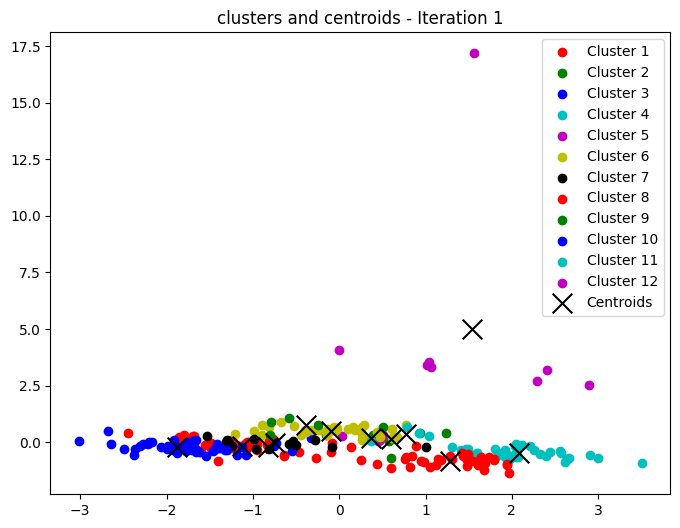

accuracy: 81.19%
F1 score: 0.56
confusion matrix:
[[43  1  0  0  0  0  2]
 [ 2 10  0  7  0  0  1]
 [ 0  0  0  0  0  0  1]
 [ 0  1  0 10  0  0  0]
 [ 0  1  0  0  6  0  0]
 [ 0  1  0  0  0  0  0]
 [ 1  0  0  1  0  0 13]]


C:\Users\Hugo\AppData\Local\Temp\ipykernel_13428\1893245688.py:11: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  most_common_label, _ = mode(int_labels[mask], axis=None)


In [80]:
#The range of k is chosen according to the size of the datasets, for most, k is tried up to 30.
highest_k = int(sqrt(X.shape[0]/2))
if highest_k < 10:
    highest_k = 10
if highest_k > 30:
    highest_k = 30
    
k_values = [i for i in range(2,highest_k+1)]
print(f'range of k values tested: [2;{highest_k}]')

#Cross-validation to find the best k
best_k = cross_validation(X_train, Y_train, k_values)
print(f"the best value of k is {best_k}")

#Centroids and cluster_labels computation using the best value of k
centroids, cluster_labels = k_means(X_train, best_k)

#Clusters labels prediction
cluster_labels = np.array([np.argmin([euclidean_distance(point, centroid) for centroid in centroids]) for point in X_test])

accuracy, f1, cm = calculate_metrics(cluster_labels, Y_test)
print(f"accuracy: {accuracy * 100:.2f}%")
print(f"F1 score: {f1:.2f}")
print(f"confusion matrix:\n{cm}")

### Iris

In [81]:
X, X_names, y, y_name = load_dataset(id = dataset_ids["iris"])
split_size = 0.7
X_train, Y_train, X_test, Y_test = preprocessing(X, y, split_size)
print(f'training set size: {X_train.shape}')
print(f'testing set size: {X_test.shape}')

data url:
 https://archive.ics.uci.edu/static/public/53/data.csv
training set size: (105, 4)
testing set size: (45, 4)


In [82]:
print_useful_data(X, X_names, y, y_name)

number of instances:  150
number of features:  4
names of the features:
 ['sepal length' 'sepal width' 'petal length' 'petal width']
name of the output label:  ['class']
instance 0 feature vector:
 [5.1 3.5 1.4 0.2]
instance 0 output label:  ['Iris-setosa']


range of k values tested: [2;10]
predicted accuracy for k=2: 72.38%

C:\Users\Hugo\AppData\Local\Temp\ipykernel_13428\1893245688.py:11: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  most_common_label, _ = mode(int_labels[mask], axis=None)



predicted accuracy for k=3: 85.71%
predicted accuracy for k=4: 84.76%
predicted accuracy for k=5: 85.71%
predicted accuracy for k=6: 90.48%
predicted accuracy for k=7: 88.57%
predicted accuracy for k=8: 90.48%
predicted accuracy for k=9: 88.57%
predicted accuracy for k=10: 91.43%
the best value of k is 10


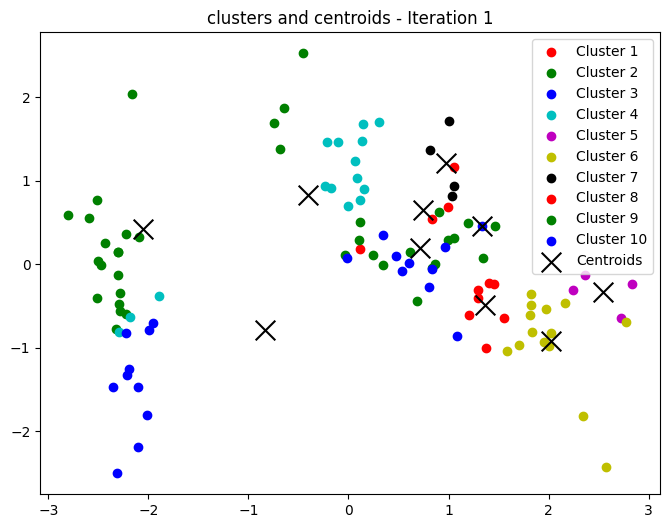

accuracy: 84.44%
F1 score: 0.81
confusion matrix:
[[19  0  0]
 [ 0  7  6]
 [ 0  1 12]]


C:\Users\Hugo\AppData\Local\Temp\ipykernel_13428\1893245688.py:11: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  most_common_label, _ = mode(int_labels[mask], axis=None)


In [83]:
#The range of k is chosen according to the size of the datasets, for most, k is tried up to 30.
highest_k = int(sqrt(X.shape[0]/2))
if highest_k < 10:
    highest_k = 10
if highest_k > 30:
    highest_k = 30
    
k_values = [i for i in range(2,highest_k+1)]
print(f'range of k values tested: [2;{highest_k}]')

#Cross-validation to find the best k
best_k = cross_validation(X_train, Y_train, k_values)
print(f"the best value of k is {best_k}")

#Centroids and cluster_labels computation using the best value of k
centroids, cluster_labels = k_means(X_train, best_k)

#Clusters labels prediction
cluster_labels = np.array([np.argmin([euclidean_distance(point, centroid) for centroid in centroids]) for point in X_test])

accuracy, f1, cm = calculate_metrics(cluster_labels, Y_test)
print(f"accuracy: {accuracy * 100:.2f}%")
print(f"F1 score: {f1:.2f}")
print(f"confusion matrix:\n{cm}")

### Zoo

In [84]:
X, X_names, y, y_name = load_dataset(id = dataset_ids["zoo"])
split_size = 0.7
X_train, Y_train, X_test, Y_test = preprocessing(X, y, split_size)
print(f'training set size: {X_train.shape}')
print(f'testing set size: {X_test.shape}')

data url:
 https://archive.ics.uci.edu/static/public/111/data.csv
training set size: (70, 16)
testing set size: (31, 16)


In [85]:
print_useful_data(X, X_names, y, y_name)

number of instances:  101
number of features:  16
names of the features:
 ['hair' 'feathers' 'eggs' 'milk' 'airborne' 'aquatic' 'predator' 'toothed'
 'backbone' 'breathes' 'venomous' 'fins' 'legs' 'tail' 'domestic'
 'catsize']
name of the output label:  ['type']
instance 0 feature vector:
 [1 0 0 1 0 0 1 1 1 1 0 0 4 0 0 1]
instance 0 output label:  [1]


range of k values tested: [2;10]
predicted accuracy for k=2: 62.86%


C:\Users\Hugo\AppData\Local\Temp\ipykernel_13428\1893245688.py:11: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  most_common_label, _ = mode(int_labels[mask], axis=None)


predicted accuracy for k=3: 74.29%
predicted accuracy for k=4: 85.71%
predicted accuracy for k=5: 91.43%
predicted accuracy for k=6: 90.00%
predicted accuracy for k=7: 92.86%
predicted accuracy for k=8: 95.71%
predicted accuracy for k=9: 92.86%
predicted accuracy for k=10: 94.29%
the best value of k is 8


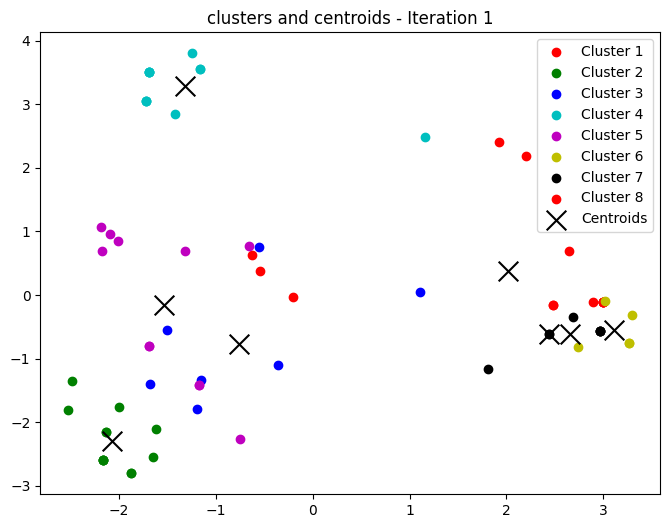

accuracy: 87.10%
F1 score: 0.65
confusion matrix:
[[15  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0]
 [ 0  0  0  1  0  0  0]
 [ 0  0  0  2  0  0  0]
 [ 0  0  0  0  2  0  0]
 [ 0  0  0  0  0  5  0]
 [ 0  0  0  0  0  3  0]]


C:\Users\Hugo\AppData\Local\Temp\ipykernel_13428\1893245688.py:11: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  most_common_label, _ = mode(int_labels[mask], axis=None)


In [86]:
#The range of k is chosen according to the size of the datasets, for most, k is tried up to 30.
highest_k = int(sqrt(X.shape[0]/2))
if highest_k < 10:
    highest_k = 10
if highest_k > 30:
    highest_k = 30
    
k_values = [i for i in range(2,highest_k+1)]
print(f'range of k values tested: [2;{highest_k}]')

#Cross-validation to find the best k
best_k = cross_validation(X_train, Y_train, k_values)
print(f"the best value of k is {best_k}")

#Centroids and cluster_labels computation using the best value of k
centroids, cluster_labels = k_means(X_train, best_k)

#Clusters labels prediction
cluster_labels = np.array([np.argmin([euclidean_distance(point, centroid) for centroid in centroids]) for point in X_test])

accuracy, f1, cm = calculate_metrics(cluster_labels, Y_test)
print(f"accuracy: {accuracy * 100:.2f}%")
print(f"F1 score: {f1:.2f}")
print(f"confusion matrix:\n{cm}")